# Miscellaneous COVID-19 Data Analyses using Johns Hopkins Data

Data sources: 

- <a href="https://github.com/CSSEGISandData/COVID-19" target="_blank">Johns Hopkins University's Center for Systems Science and Engineering (CSSE) COVID-19 data repository</a>
- <a href="https://worldpopulationreview.com/states/" target="_blank">World Population Review</a> (for state population data).

The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19](https://github.com/bmc/covid19/).


## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from lib.common import *
from itertools import chain

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2


In [2]:
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## State population data

In [4]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,157


## Read the data

In [5]:
from dataclasses import dataclass

@dataclass(frozen=True)
class JHUStateData:
    state: str
    deaths: int
    cases: int
    recovered: int
    tested: int
    hospitalized: int
    mortality_rate: float
        

def read_jhu_data(path):
    """
    Read and load one JHU data file. Returns a dictionary indexed by full
    state name, with the statistics for that state represented in a JHUStateData
    object.
    """
    data_by_state = dict()
    with open(path, mode='r', encoding='UTF-8') as f:
        c = csv.DictReader(f)
        for row in c:
            state = row['Province_State']
            data_by_state[state] = JHUStateData(
                state=state,
                cases=csv_int_field(row, 'Confirmed'),
                deaths=csv_int_field(row, 'Deaths'),
                recovered=csv_int_field(row, 'Recovered'),
                tested=csv_int_field(row, 'People_Tested'),
                hospitalized=csv_int_field(row, 'People_Hospitalized'),
                mortality_rate=csv_float_field(row, 'Mortality_Rate'),
            )
    return data_by_state

def read_all():
    """
    Read all the data files in the appropriate JHU/CSSE directory. The data files
    are named after the date, in this format: 04-21-2020.csv. This function
    identifies all such files and reads them into a dictionary indexed by date.
    Each value in the dictionary is a another dictionary indexed by full state name
    and pointing to a JHUStateDate object.
    """
    jhu_data = dict()
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        m = f_pat.match(f)
        if m is None:
            continue
        date = datetime.strptime(m.group(1), '%m-%d-%Y').date()
        jhu_data[date] = read_jhu_data(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
    return jhu_data

In [6]:
jhu_data = read_all()
print(f"Read data for {len(jhu_data)} days.")
jhu_starting_date = min(jhu_data.keys())
jhu_ending_date = max(jhu_data.keys())
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Read data for 102 days.
Starting date: 04/12/2020
Ending date: 07/22/2020


In [7]:
dates_in_order = sorted(jhu_data.keys())

In [8]:
x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_recovered = []
total_hospitalized = []
total_tested = []

for date in dates_in_order:
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.cases for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))
    total_hospitalized.append(sum([j.hospitalized for state, j in data.items()]))
    total_tested.append(sum([j.tested for state, j in data.items()]))

## Deaths and recoveries across the US

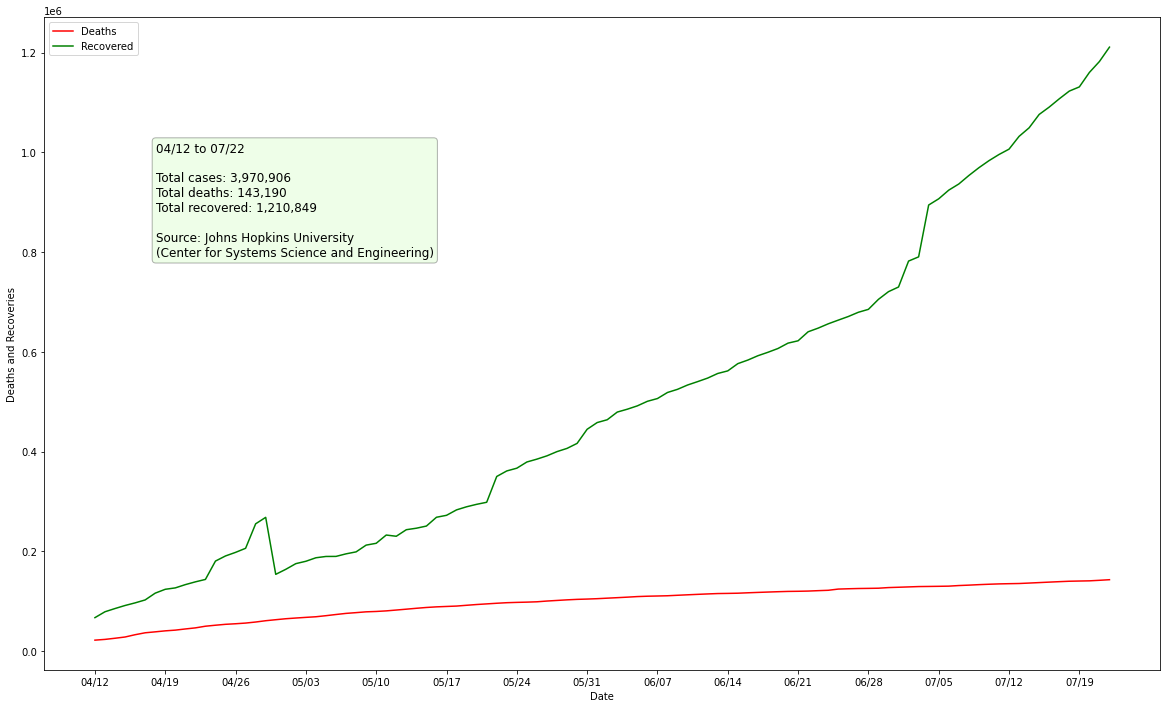

In [9]:
# Line chart plot of deaths and recoveries.

fig, ax = p.subplots(figsize=(20, 12))

ax.plot(x_dates, total_deaths, color='red', label='Deaths')
#ax.plot(x_dates, total_cases, color='blue', label='Cases')
ax.plot(x_dates, total_recovered, color='green', label='Recovered')

ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Deaths and Recoveries')
ax.legend()
text = f"""{x_dates[0]} to {x_dates[-1]}

Total cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}
Total recovered: {total_recovered[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.1, 0.81, text)
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-us-deaths-recoveries.png'))

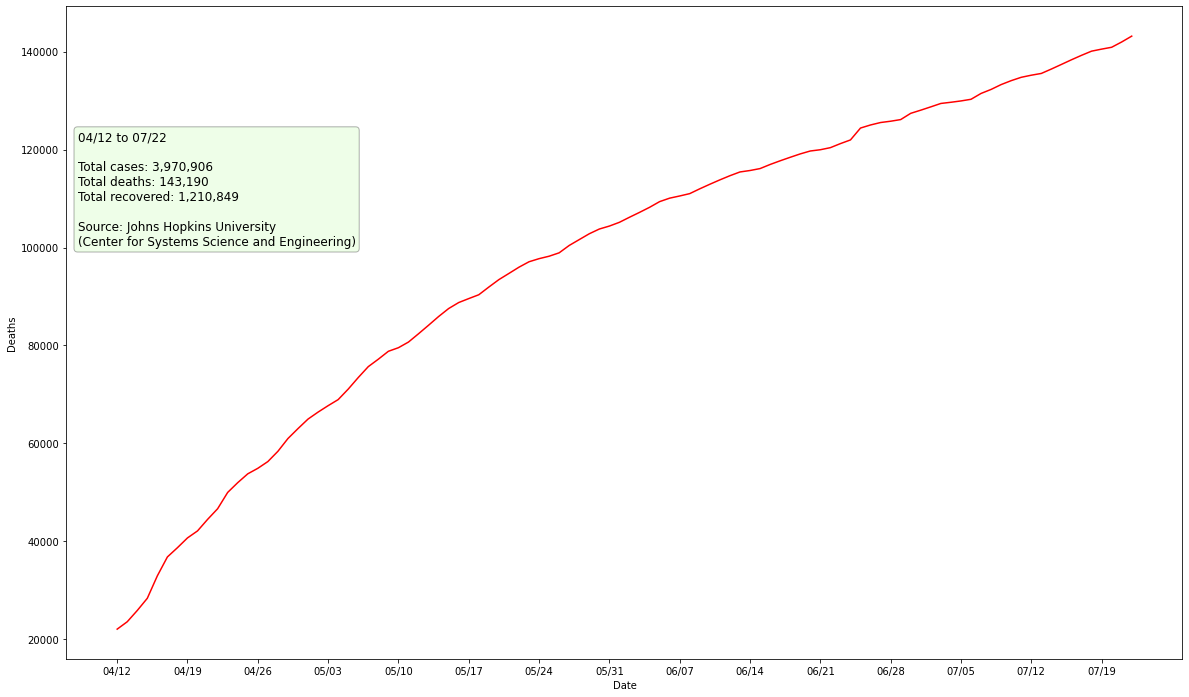

In [10]:
# Deaths only.

fig, ax = p.subplots(figsize=(20, 12))

ax.plot(x_dates, total_deaths, color='red', label='Deaths')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')
text = f"""{x_dates[0]} to {x_dates[-1]}

Total cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}
Total recovered: {total_recovered[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.81, text)
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-us-deaths.png'))

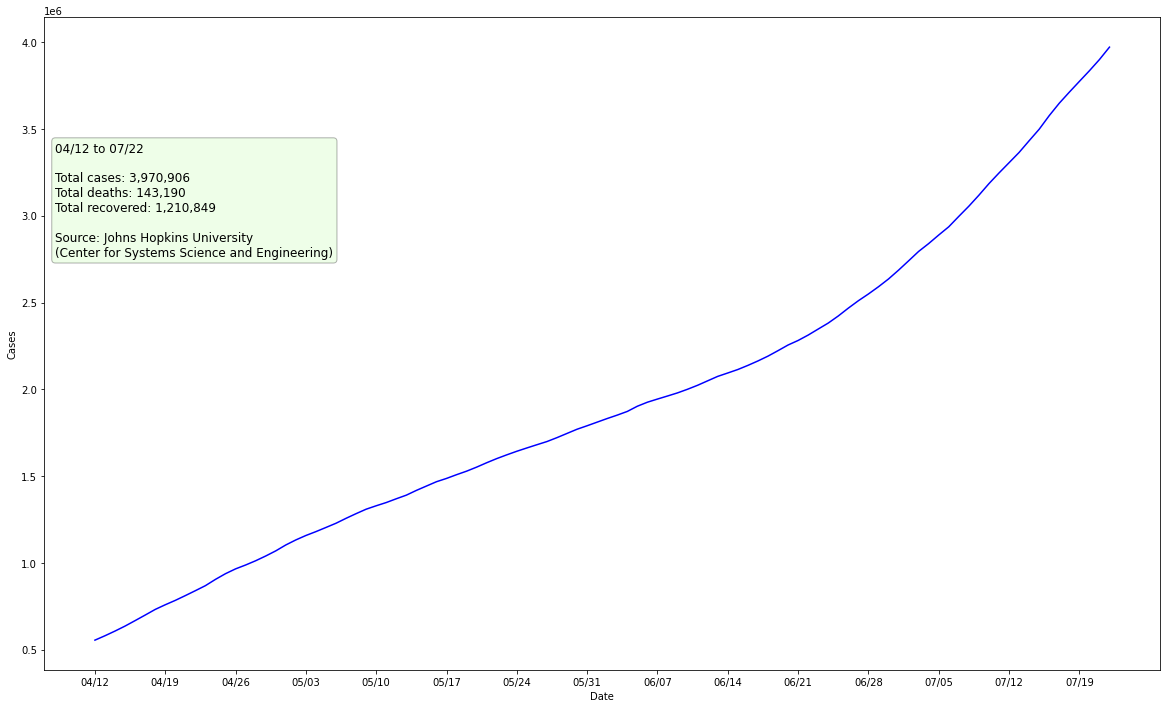

In [11]:
# Cases only.

fig, ax = p.subplots(figsize=(20, 12))

ax.plot(x_dates, total_cases, color='blue', label='Cases')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
ax.set_xlabel('Date')
ax.set_ylabel('Cases')
text = f"""{x_dates[0]} to {x_dates[-1]}

Total cases: {total_cases[-1]:,}
Total deaths: {total_deaths[-1]:,}
Total recovered: {total_recovered[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.81, text)
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-us-deaths.png'))

### Just the past week

In [12]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
print(datestr(six_days_prior, include_year=True))
print(datestr(jhu_ending_date, include_year=True))

07/16/2020
07/22/2020


U.S. Deaths: 07/16 through 07/22

Total deaths on 07/16: 138,358
Total deaths on 07/22: 143,190
Deaths during period: 5,783

Source: Johns Hopkins University
(Center for Systems Science and Engineering)


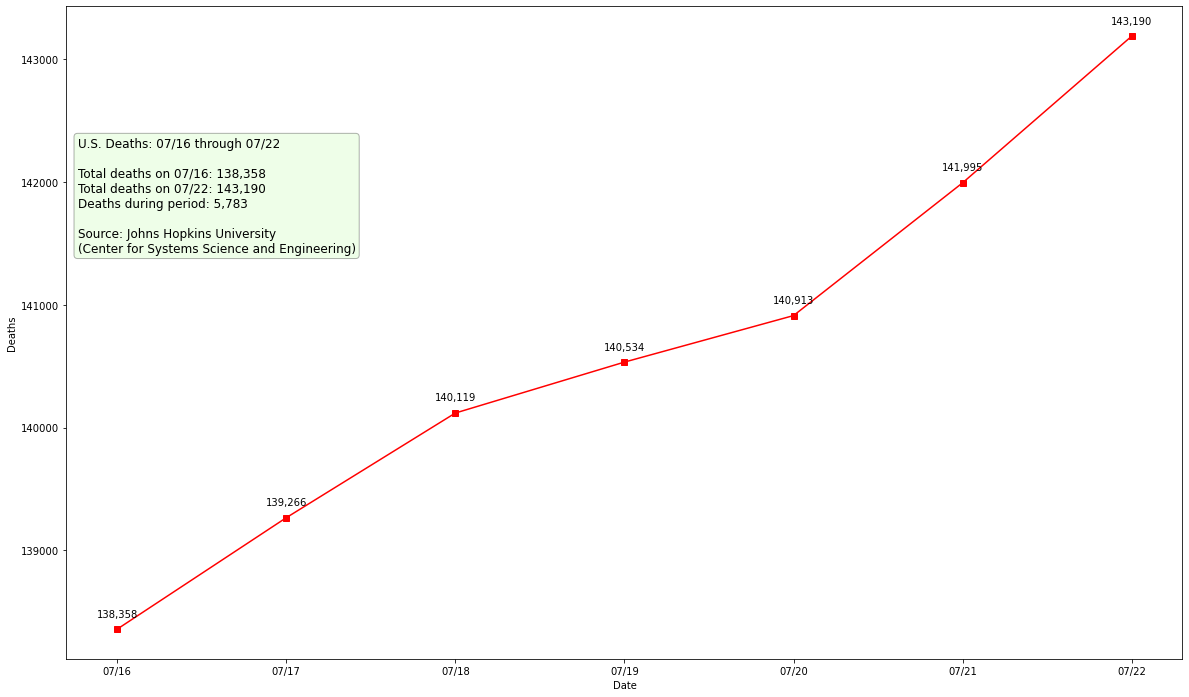

In [13]:
fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order if d >= six_days_prior]
deaths_a_week_ago = sum([j.deaths for state, j in jhu_data[jhu_ending_date - timedelta(days=7)].items()])
total_deaths = []
total_cases = []
total_recovered = []

for date in dates_in_order:
    if date < six_days_prior:
        continue
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.cases for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))

ax.plot(x_dates, total_deaths, color='red', label='Deaths', marker='s')
ax.set_xlabel('Date')
ax.set_ylabel('Deaths')

# Put the actual numbers on the chart.
for x, y in zip(x_dates, total_deaths):
    label = f"{y:,}"
    # The xytext values are absolute — and kind of fiddly.
    ax.annotate(label, (x, y), ha='center', xytext=(x, y+100))

text = f"""U.S. Deaths: {x_dates[0]} through {x_dates[-1]}

Total deaths on {x_dates[0]}: {total_deaths[0]:,}
Total deaths on {x_dates[-1]}: {total_deaths[-1]:,}
Deaths during period: {(total_deaths[-1] - deaths_a_week_ago):,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.80, text)
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-us-deaths-past-week.png'))
print(text)

## Deaths vs. Cases

U.S. COVID-19: 04/12 through 07/22

Total deaths: 143,190
Total people recovered: 1,210,849
Total people tested: 48,020,777
Total cases: 3,970,906

Source: Johns Hopkins University
(Center for Systems Science and Engineering)


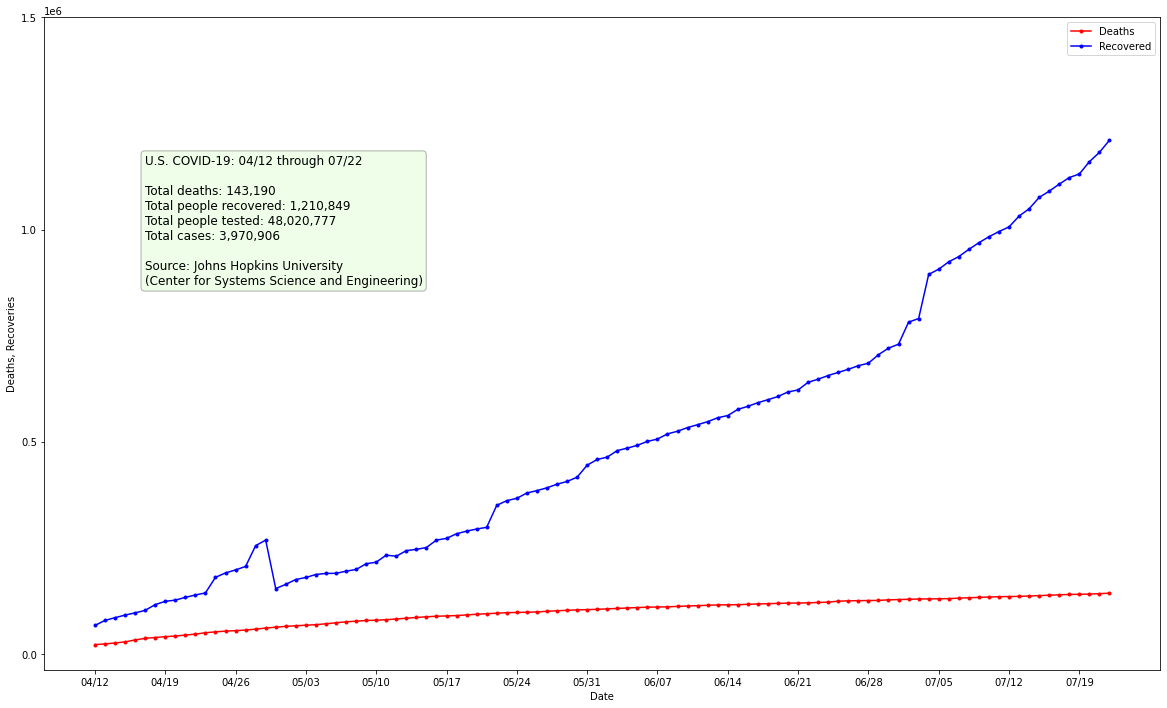

In [14]:
fig, ax = p.subplots(figsize=(20, 12))
x_dates = [datestr(d) for d in dates_in_order]
total_deaths = []
total_cases = []
total_tested = []
total_recovered = []

for date in dates_in_order:
    data = jhu_data[date]
    total_deaths.append(sum([j.deaths for state, j in data.items()]))
    total_cases.append(sum([j.cases for state, j in data.items()]))
    total_tested.append(sum([j.tested for state, j in data.items()]))
    total_recovered.append(sum([j.recovered for state, j in data.items()]))
    
ax.plot(x_dates, total_deaths, color='red', label='Deaths', marker='.')
ax.plot(x_dates, total_recovered, color='blue', label='Recovered', marker='.')
#ax.plot(x_dates, total_tested, color='green', label='Tested', marker='.')
#ax.plot(x_dates, total_cases, color='orange', label='All Cases', marker='.')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days

#max_number = max(total_deaths[-1], total_tested[-1], total_cases[-1], total_recovered[-1])
max_number = max(total_deaths[-1], total_recovered[-1])
ymax, stride = determine_ymax_and_stride(max_number)
ax.set_yticks(range(0, ymax)[::stride])
ax.set_xlabel('Date')
ax.set_ylabel('Deaths, Recoveries')

ax.legend()

text = f"""U.S. COVID-19: {x_dates[0]} through {x_dates[-1]}

Total deaths: {total_deaths[-1]:,}
Total people recovered: {total_recovered[-1]:,}
Total people tested: {total_tested[-1]:,}
Total cases: {total_cases[-1]:,}

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.09, 0.79, text)
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-us-deaths-recoveries.png'))
print(text)

## Mortality rates over time

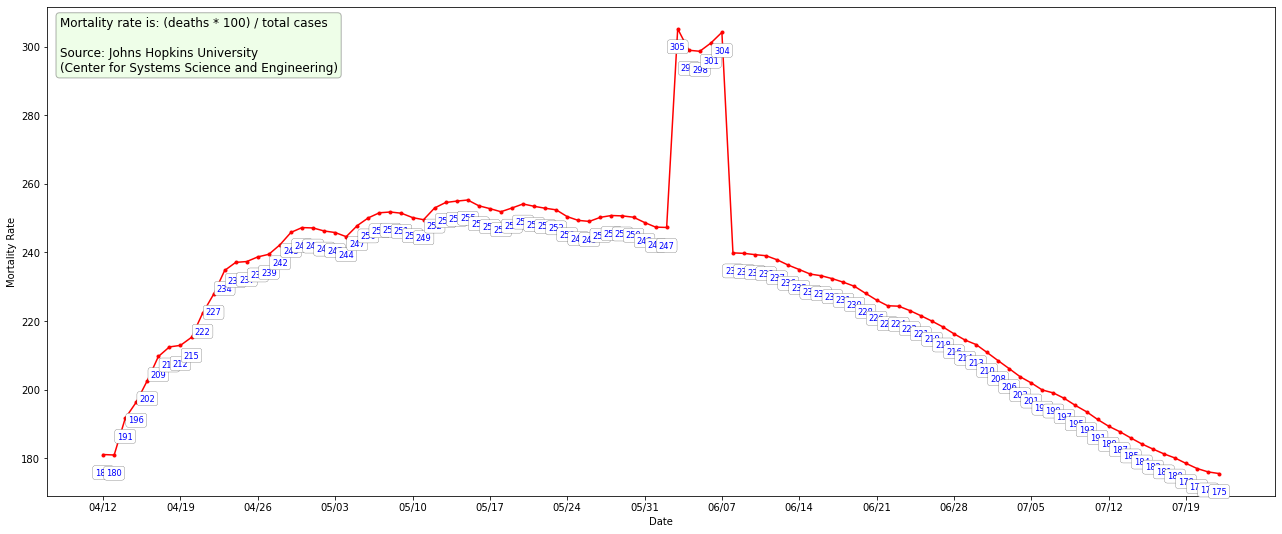

In [15]:
fig, ax = p.subplots(figsize=(22, 9))
x_dates = [datestr(d) for d in dates_in_order]
total_mortality_rate = []

for date in dates_in_order:
    data = jhu_data[date]
    total_mortality_rate.append(sum([j.mortality_rate for state, j in data.items()]))
    
ax.plot(x_dates, total_mortality_rate, color='red', label='Mortality Rate', marker='.')
ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days

#max_number = max(total_deaths[-1], total_tested[-1], total_cases[-1], total_recovered[-1])
#max_number = max(total_deaths[-1], total_recovered[-1])
#ymax, stride = determine_ymax_and_stride(max_number)
#ax.set_yticks(range(0, ymax)[::stride])
ax.set_xlabel('Date')
ax.set_ylabel('Mortality Rate')

x_coordinates = [i for i, _ in enumerate(x_dates)]
# Put the actual numbers on the chart.
for x, y in zip(x_coordinates, total_mortality_rate):
    label = f"{int(y):,}"
    # The xytext values are absolute — and kind of fiddly.
    box_props = {
        'boxstyle': 'round',
        'facecolor': 'white',
        'linewidth': 0.2,
        'alpha': 1.0,
    }
    ax.annotate(label, (x, int(y)), ha='center', xytext=(x, y-6),
                bbox=box_props, fontsize='small', color='blue')

#ax.legend()

text = f"""Mortality rate is: (deaths * 100) / total cases

Source: Johns Hopkins University
(Center for Systems Science and Engineering)"""
textbox(ax, 0.01, 0.98, text)
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-us-mortality.png'))

## Individual States

In [16]:
def plot_state(state, fig=None, ax=None, image_file=None, metrics={MetricType.DEATHS}, start_date=None, per_n=1):
    if ax is None:
        fig, ax = p.subplots(figsize=(20, 12))

    dates = dates_in_order
    if start_date is not None:
        dates = [d for d in dates_in_order if d >= start_date]

    x_dates = [datestr(d) for d in dates]
    total_deaths = []
    total_cases = []
    total_recovered = []
    total_hospitalized = []
    total_tested = []

    def do_per_n(value: int) -> int:
        return int(round(value / per_n))

    for date in dates:
        data = jhu_data[date][state]
        if per_n != 1:
            total_deaths.append(do_per_n(data.deaths))
            total_cases.append(do_per_n(data.cases))
            total_recovered.append(do_per_n(data.recovered))
            total_hospitalized.append(do_per_n(data.hospitalized))
            total_tested.append(do_per_n(data.tested))
        else:
            total_deaths.append(data.deaths)
            total_cases.append(data.cases)
            total_recovered.append(data.recovered)
            total_hospitalized.append(data.hospitalized)
            total_tested.append(data.tested)

    y_labels = []
    max_deaths = total_deaths[-1]
    max_cases = total_cases[-1]
    max_hospitalizations = total_hospitalized[-1]
    max_tested = total_tested[-1]
    max_y = 0
    text_lines = [f"{state}: {x_dates[0]} to {x_dates[-1]}", ""]
    plotted = 0

    def plot(values, color, label):
        nonlocal plotted
        if (len(values) > 0) and (values[-1] > 0):
            ax.plot(x_dates, values, color=color, label=label)
            plotted += 1

    if MetricType.DEATHS in metrics:
        plot(total_deaths, color='red', label='Deaths')
        y_labels.append('Deaths')
        max_y = max(max_y, max_deaths)
        text_lines.append(f"Total deaths: {max_deaths:,}")

    if MetricType.CASES in metrics:
        plot(total_cases, color='blue', label='Cases')
        y_labels.append('Cases')
        max_y = max(max_y, max_cases)
        text_lines.append(f"Total cases: {max_cases:,}")

    if MetricType.HOSPITALIZATIONS in metrics:
        if max_hospitalizations <= 0:
            textbox(ax, 0.01, 0.99, f"ERROR: No data on hospitalizations for {state}")
        else:
            plot(total_hospitalized, color='green', label='Hospitalized')
            y_labels.append('Hospitalized')
            max_y = max(max_y, max_hospitalizations)
        hospitalization_summary = f"{max_hospitalizations:,}" if max_hospitalizations > 0 else "No data on hospitalizations"
        text_lines.append(f"Total hospitalizations: {hospitalization_summary}")

    if MetricType.TESTED in metrics:
        plot(total_tested, color='orange', label='Tested')
        y_labels.append('Tested')
        max_y = max(max_y, max_tested)
        tested_summary = f"{max_tested:,}" if max_tested > 0 else "No data on number tested"
        text_lines.append(f"Total tested: {tested_summary}")


    if MetricType.RECOVERIES in metrics:
        print('Warning: Plotting recoveries is not currently supported.')

    if max_y > 0:
        ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days
        y_label = ', '.join(y_labels)
        if per_n > 1:
            y_label = f"{y_label} (per {per_n:,} people)"
        ymax, stride = determine_ymax_and_stride(max_y)
        ax.set_yticks(range(0, ymax)[::stride])
        ax.set_xlabel('Date')
        ax.set_ylabel(y_label)
        if plotted > 1:
            ax.legend(loc='upper left')

        text_lines.append("Source: Johns Hopkins University")
        text_lines.append("(Center for Systems Science and Engineering)")

        text_x = 0.1 if len(metrics) > 1 else 0.01

        textbox(ax, text_x, 0.99, '\n'.join(text_lines))

        if image_file is not None:
            fig.savefig(os.path.join(IMAGES_PATH, image_file))
        
    return (fig, ax)

#### Pennsylvania

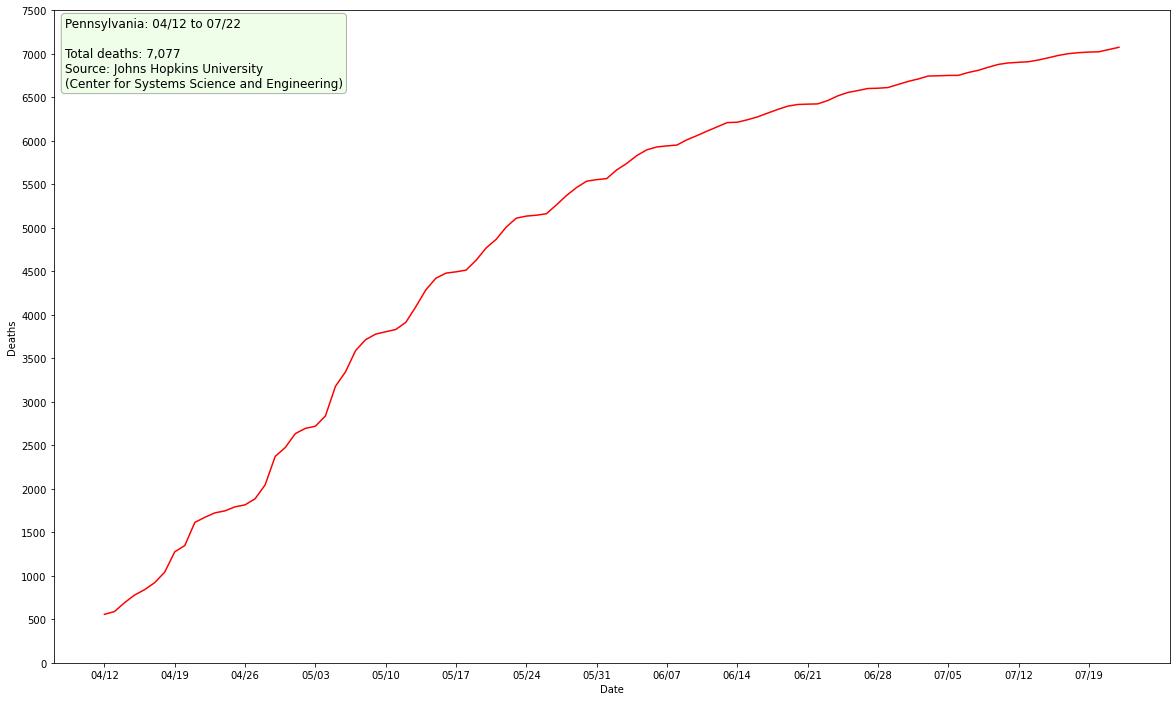

In [17]:
fig, ax = plot_state('Pennsylvania', image_file="jhu-pa-deaths.png")

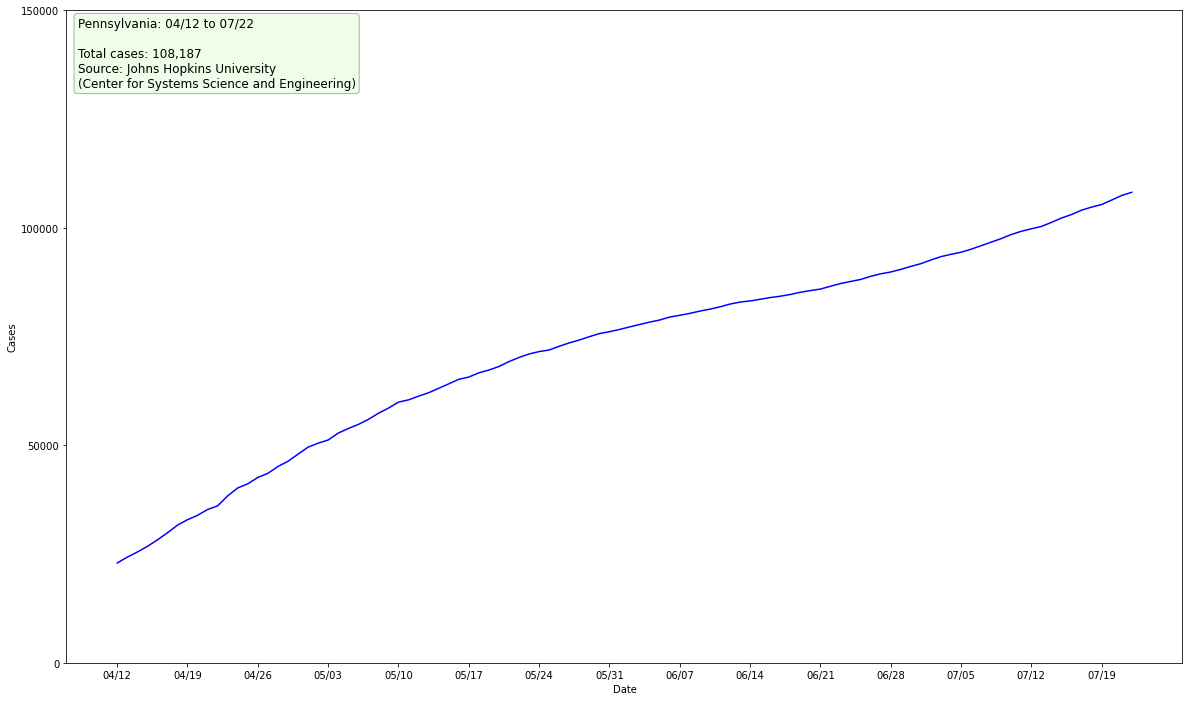

In [18]:
fig, ax = plot_state('Pennsylvania', image_file="jhu-pa-cases.png", metrics={MetricType.CASES})

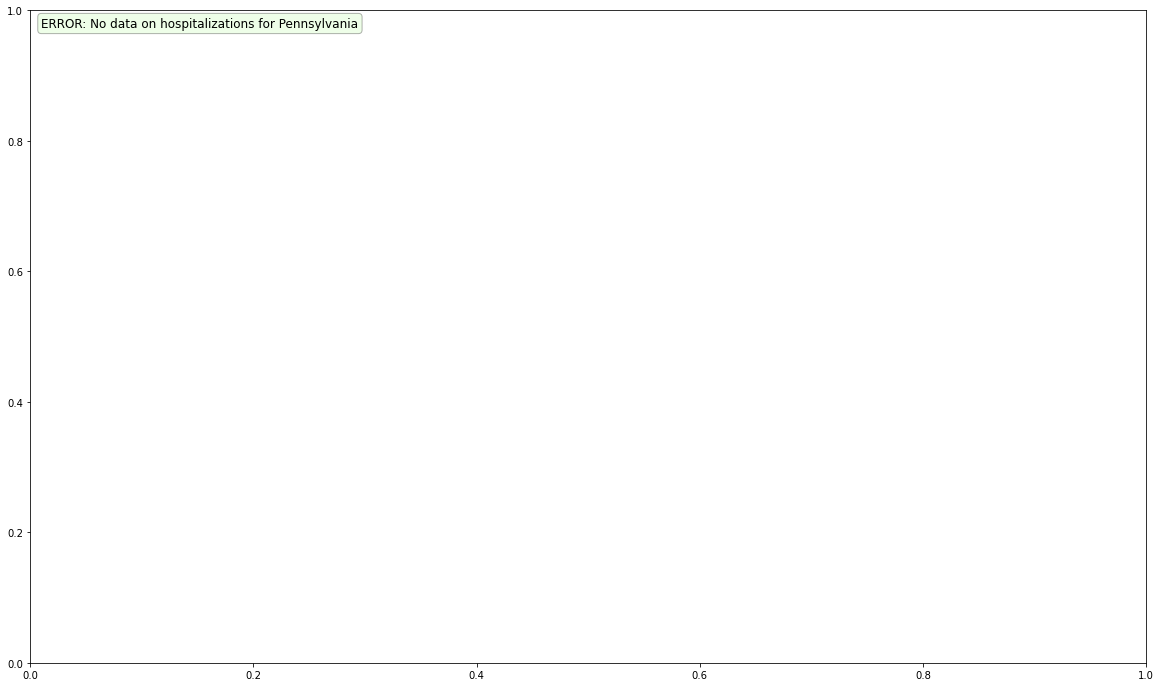

In [19]:
fig, ax = plot_state('Pennsylvania', image_file="jhu-pa-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

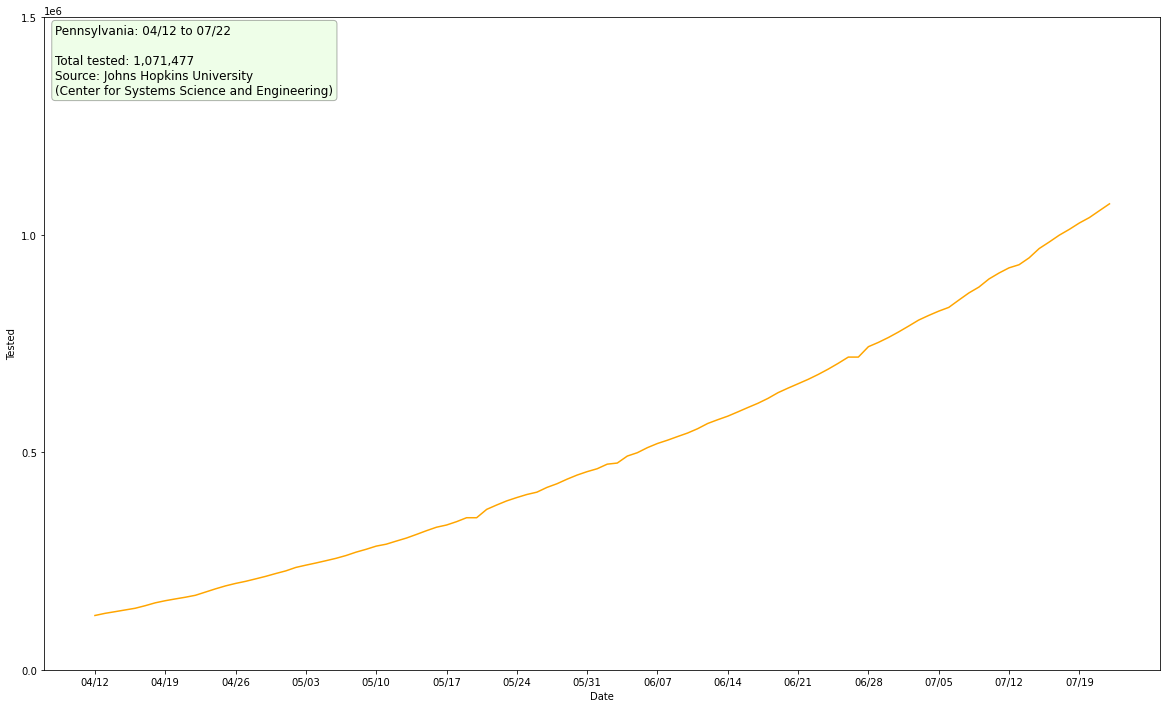

In [20]:
fig, ax = plot_state('Pennsylvania', image_file="jhu-pa-tested.png", metrics={MetricType.TESTED})

### New York

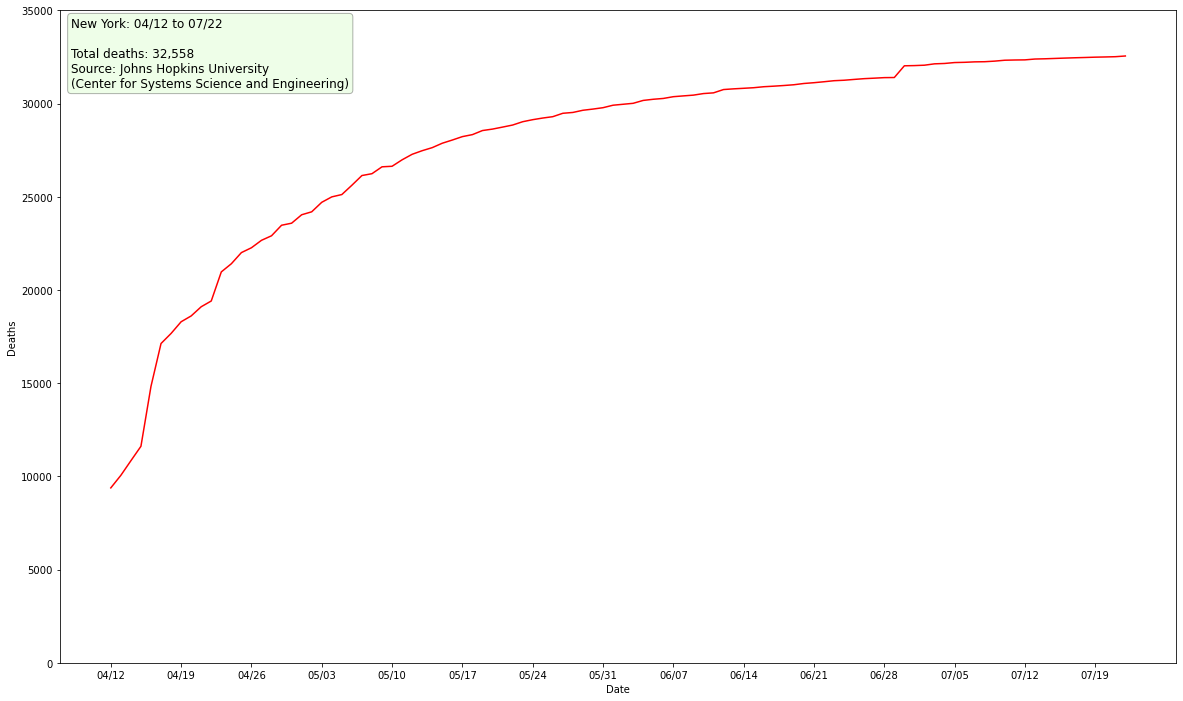

In [21]:
ax, fig = plot_state('New York', image_file="jhu-ny-deaths.png")

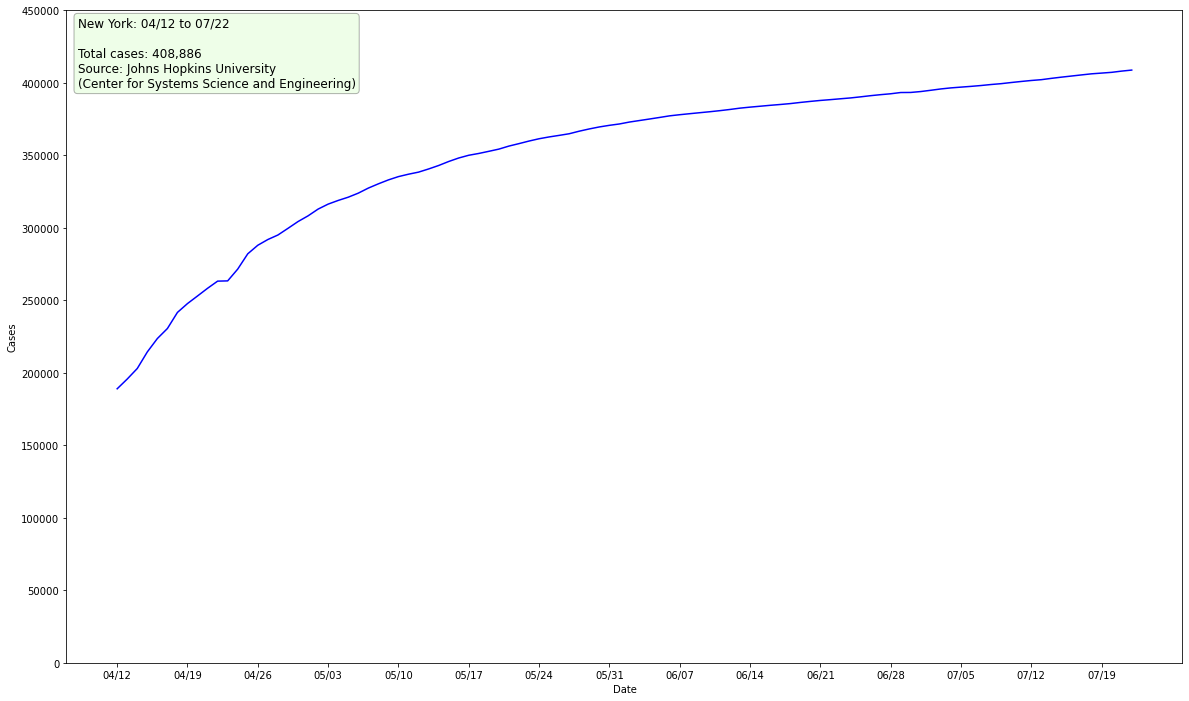

In [22]:
ax, fig = plot_state('New York', image_file="jhu-ny-cases.png", metrics={MetricType.CASES})

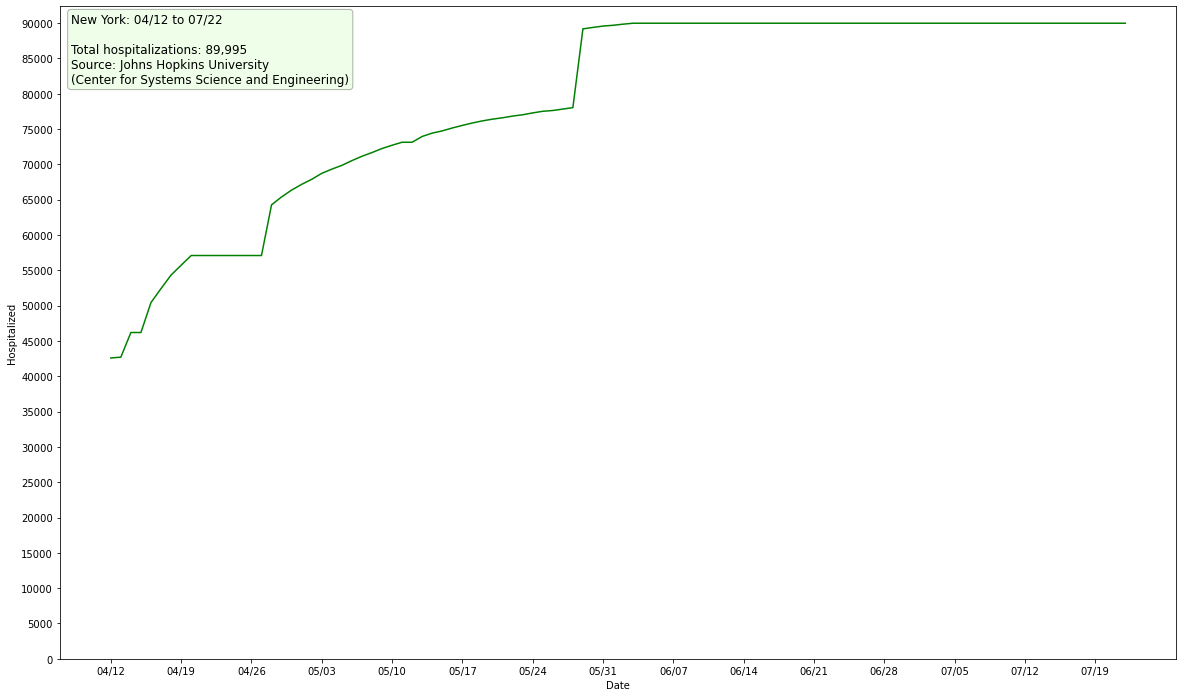

In [23]:
ax, fig = plot_state('New York', image_file="jhu-ny-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

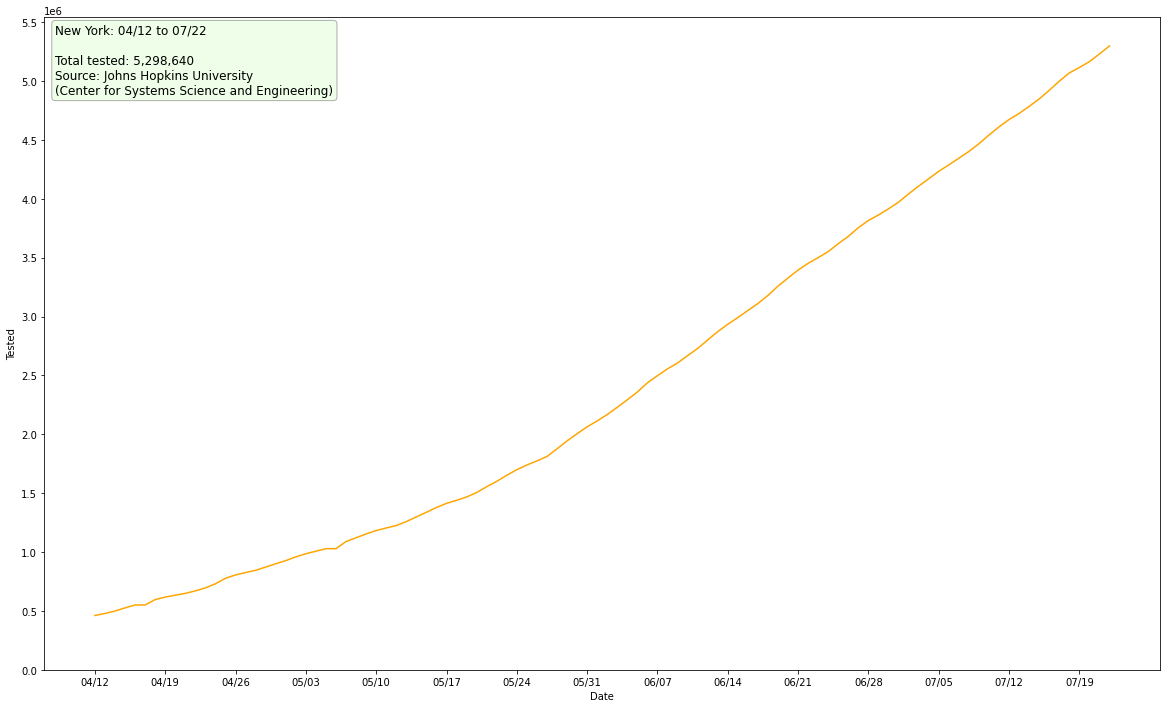

In [24]:
ax, fig = plot_state('New York', image_file="jhu-ny-tested.png", metrics={MetricType.TESTED})

### Washington

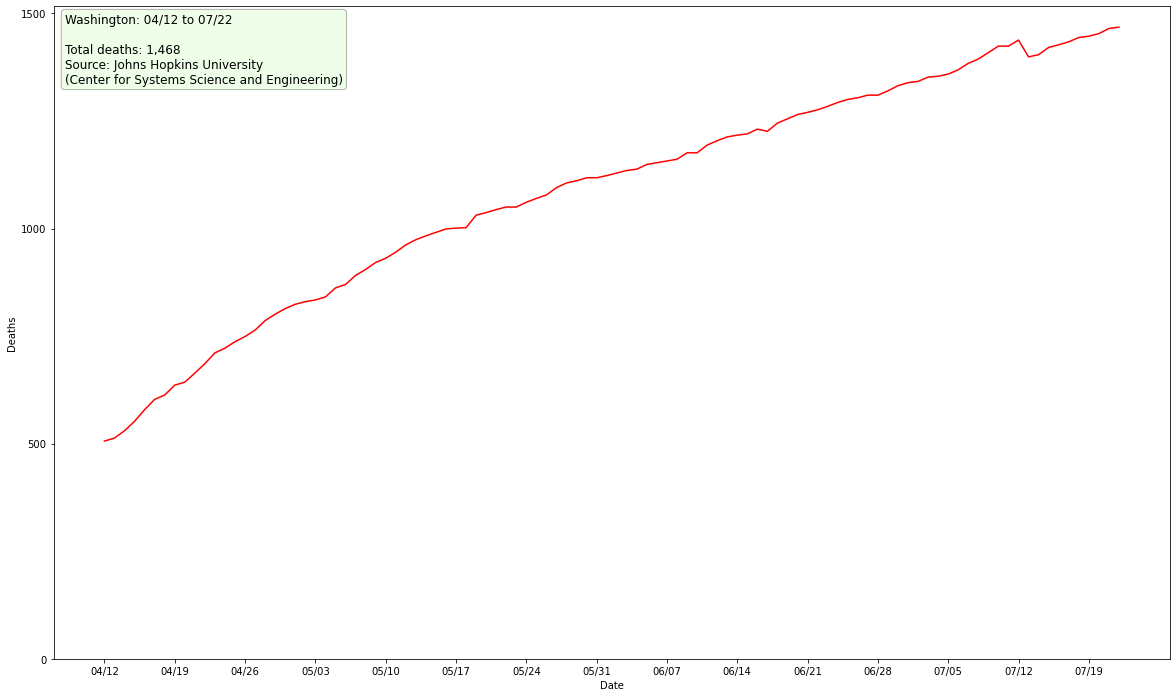

In [25]:
fig, ax = plot_state('Washington', image_file="jhu-wa-deaths.png")

### Delaware

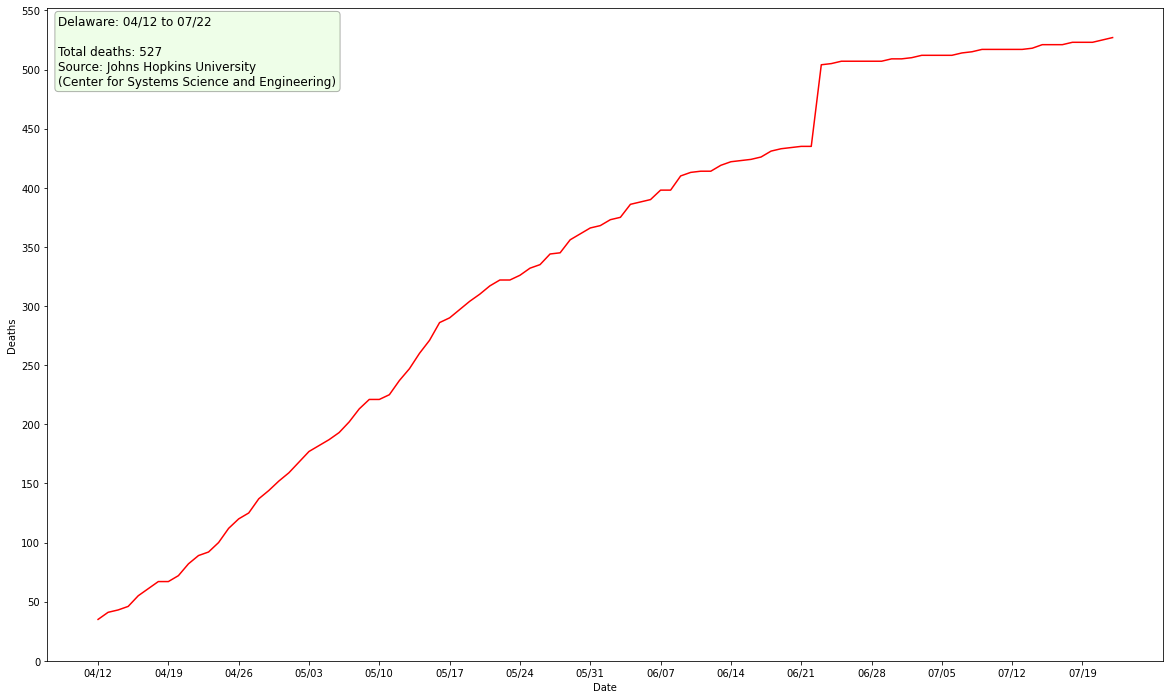

In [26]:
fig, ax = plot_state('Delaware', image_file='jhu-de-deaths.png')

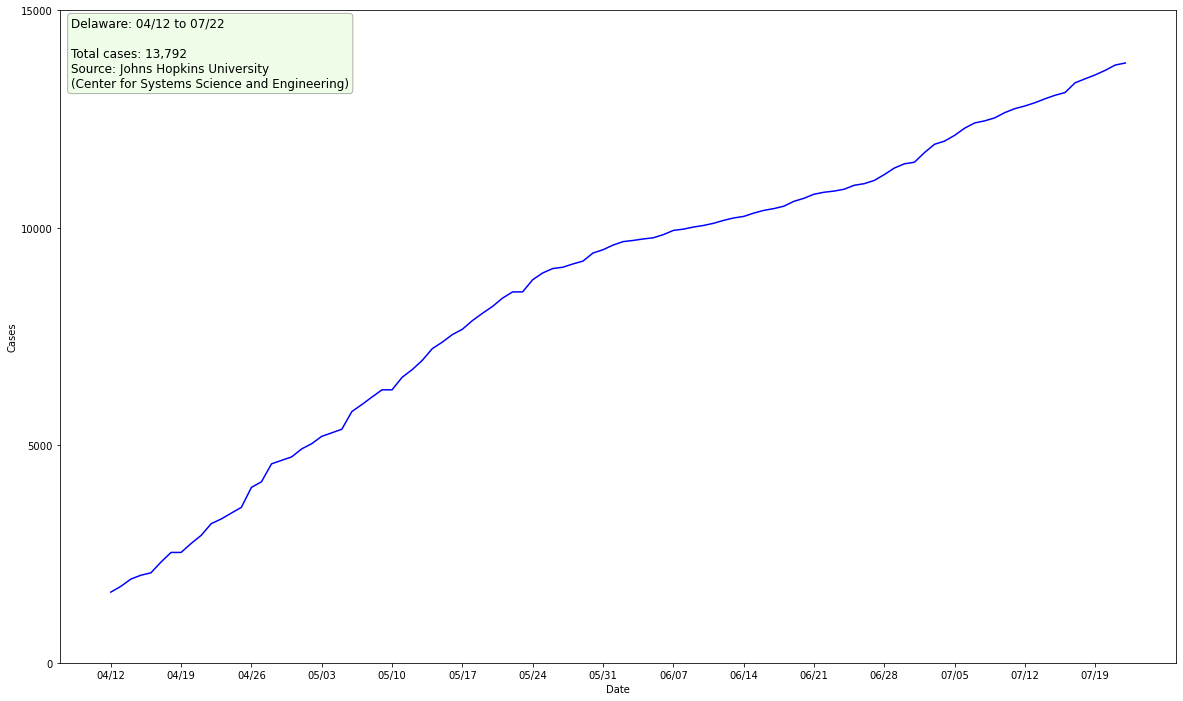

In [27]:
fig, ax = plot_state('Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES})

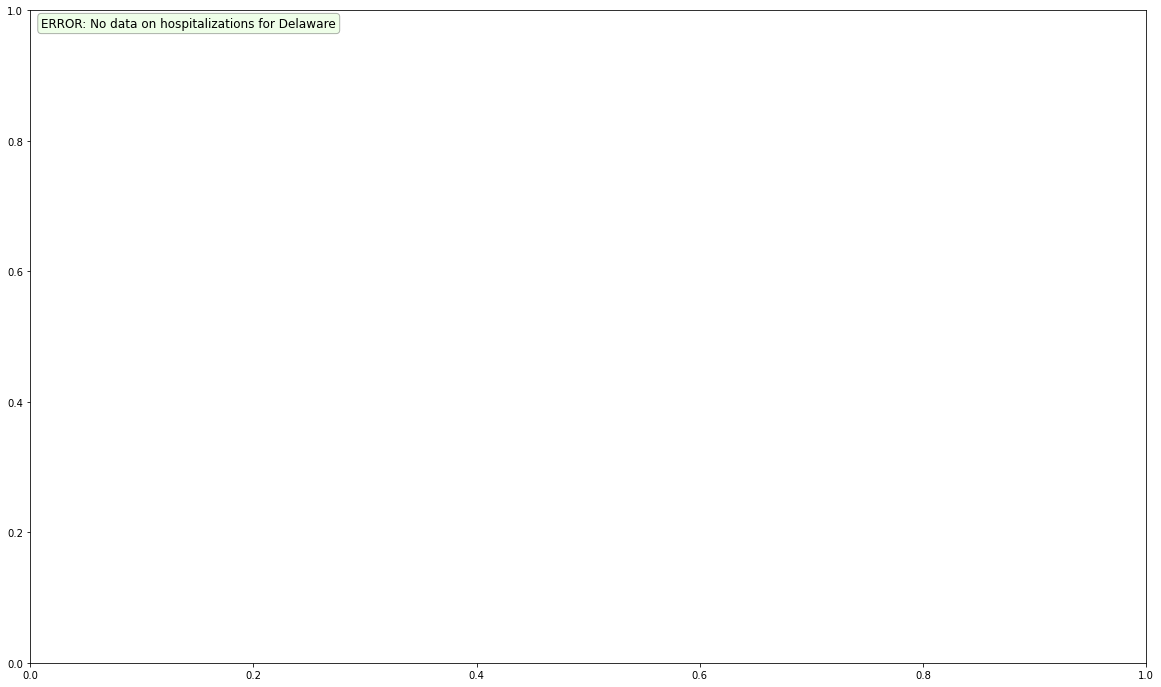

In [28]:
fig, ax = plot_state('Delaware', image_file='jhu-de-hosp.png', metrics={MetricType.HOSPITALIZATIONS})

### Texas

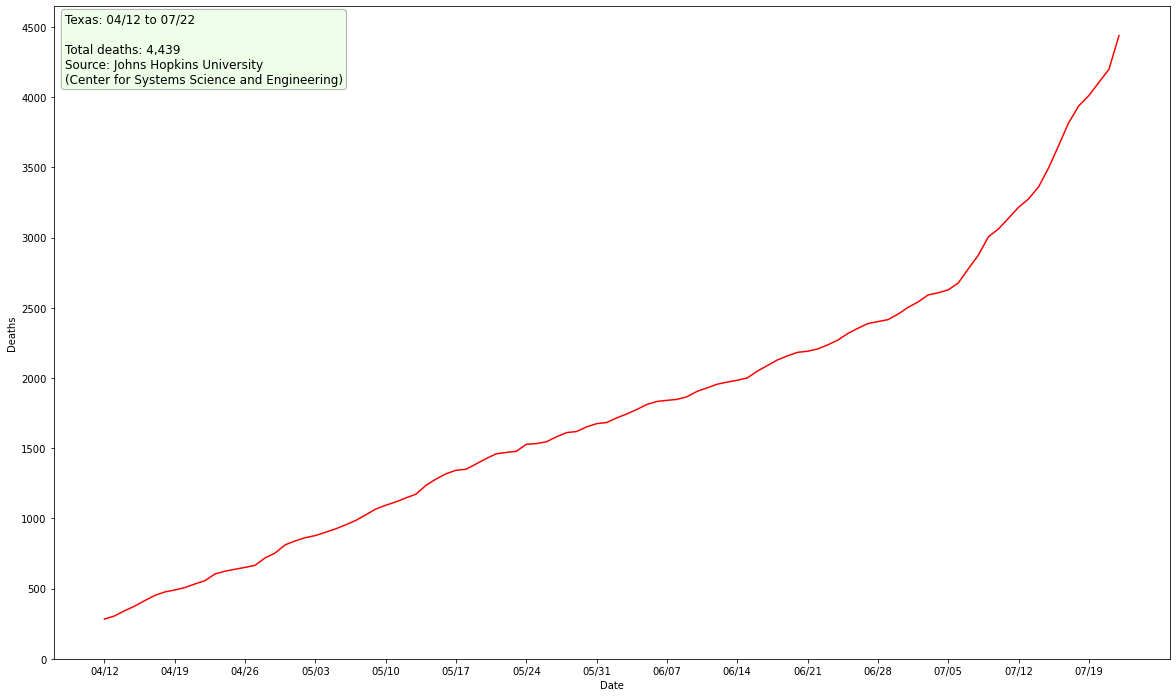

In [29]:
ax, fig = plot_state('Texas', image_file="jhu-tx-deaths.png")

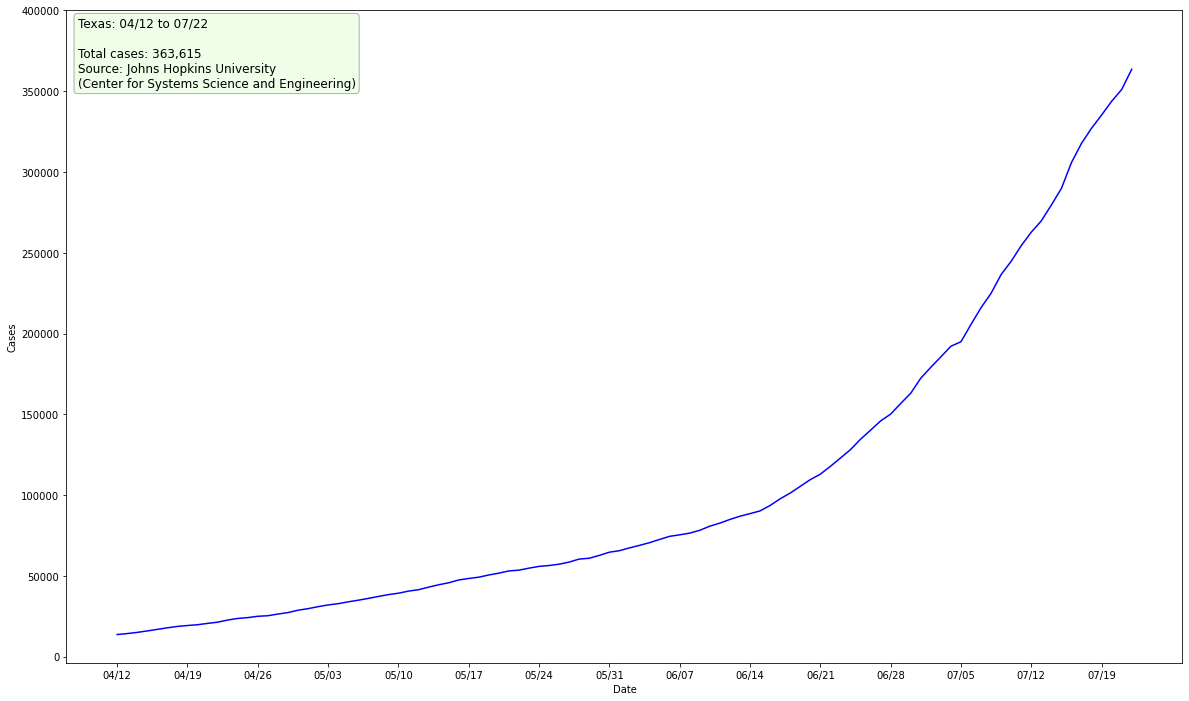

In [30]:
ax, fig = plot_state('Texas', image_file="jhu-tx-cases.png", metrics={MetricType.CASES})

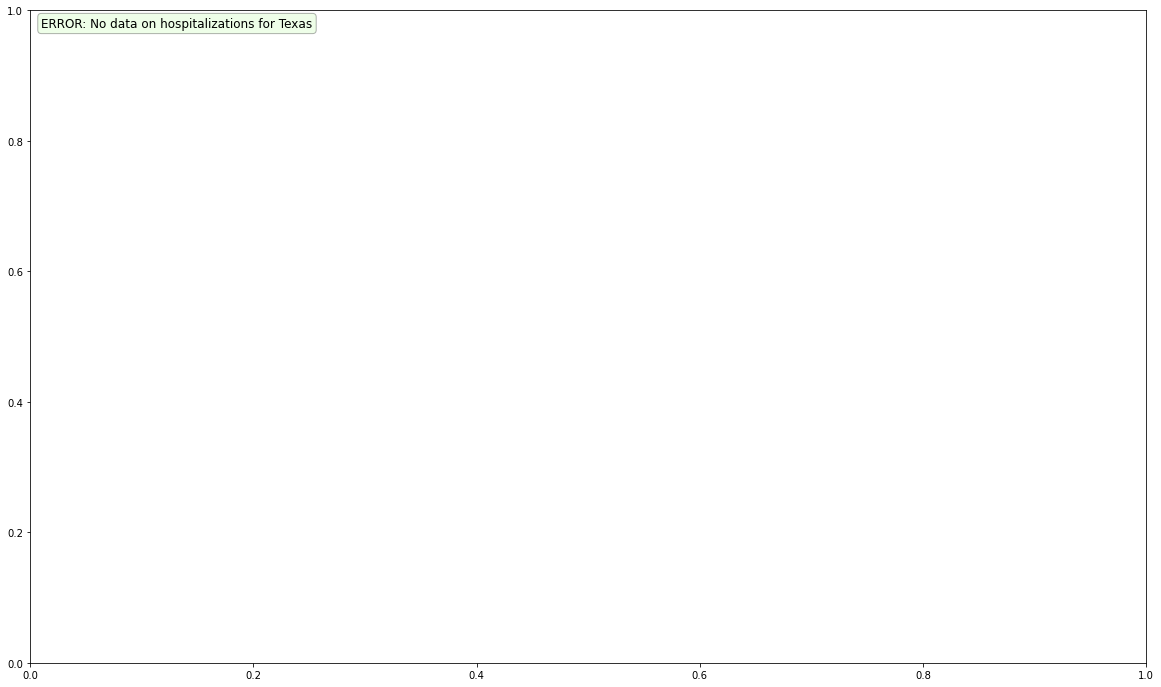

In [31]:
ax, fig = plot_state('Texas', image_file="jhu-tx-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

### Georgia

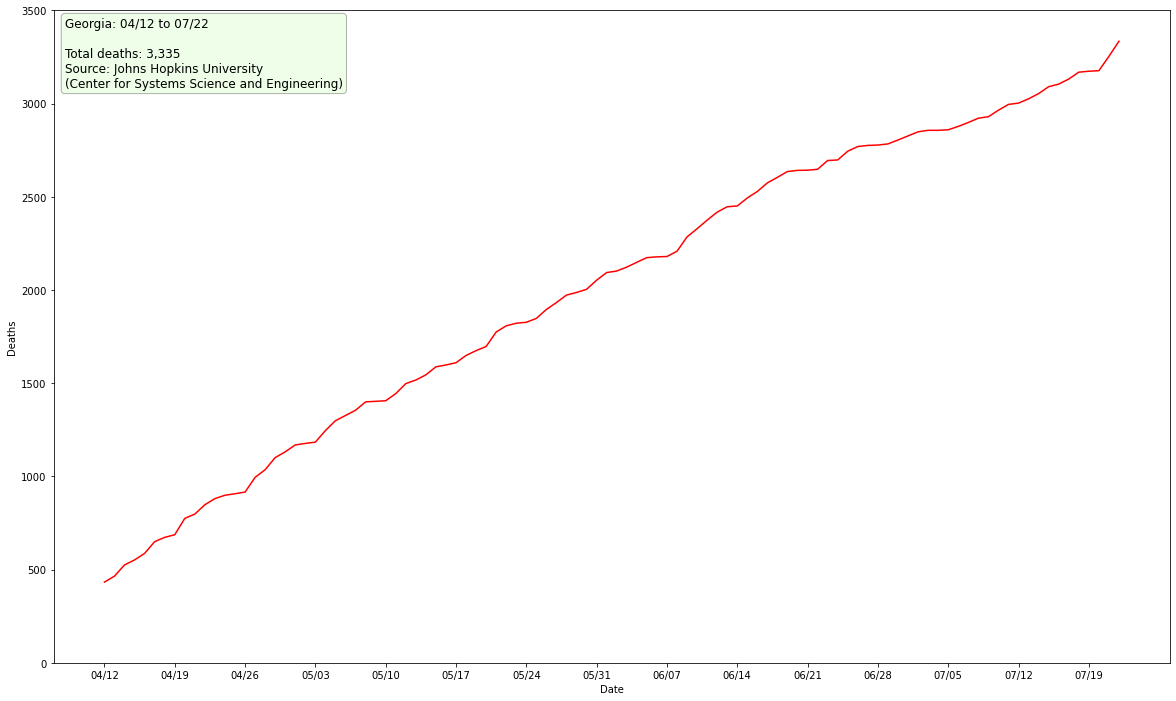

In [32]:
ax, fig = plot_state('Georgia', image_file="jhu-ga-deaths.png")

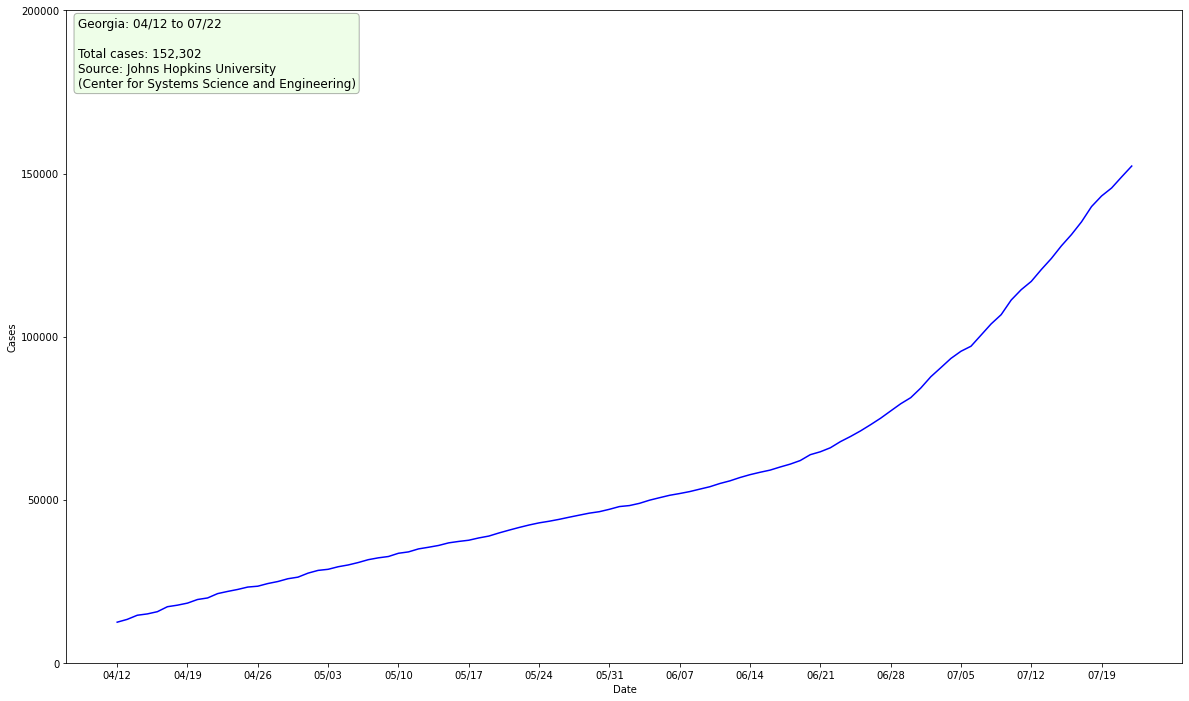

In [33]:
ax, fig = plot_state('Georgia', image_file="jhu-ga-cases.png", metrics={MetricType.CASES})

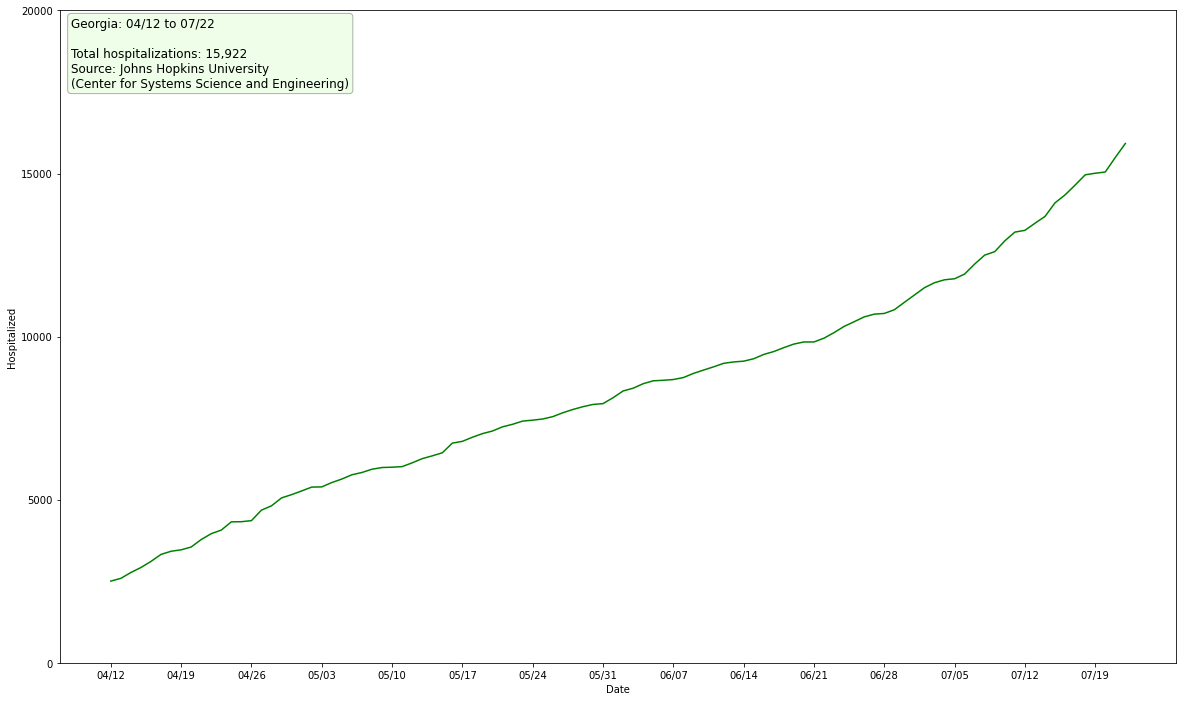

In [34]:
ax, fig = plot_state('Georgia', image_file="jhu-ga-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

### Mississippi

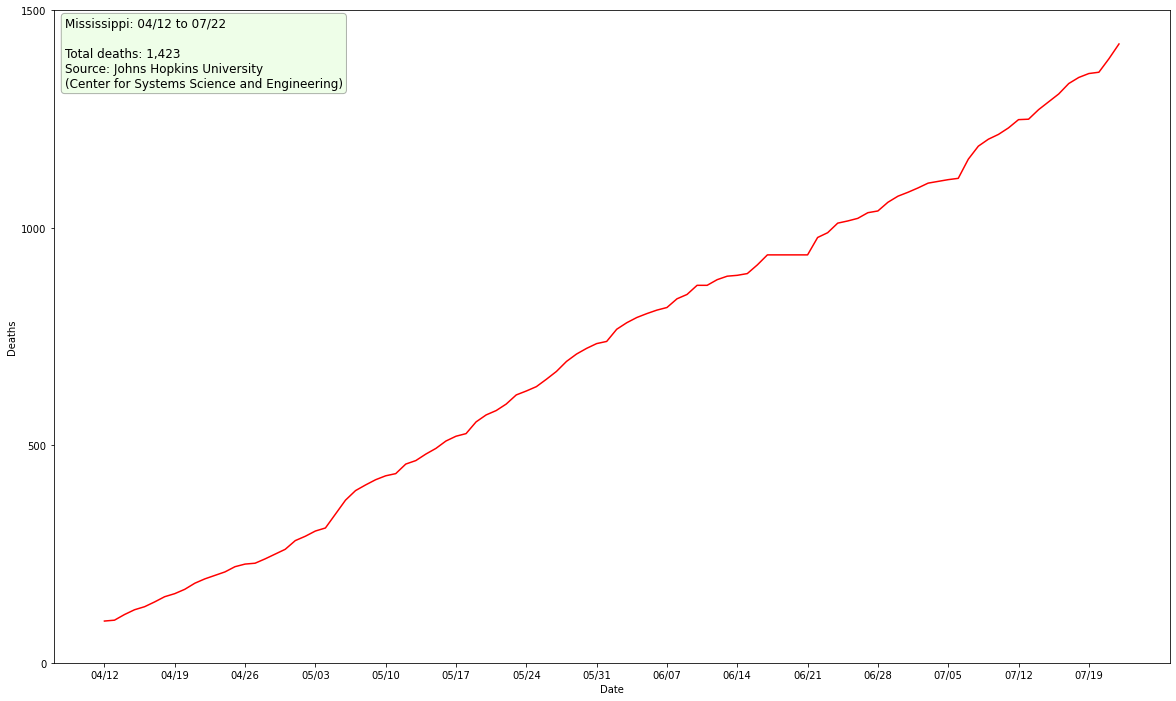

In [35]:
ax, fig = plot_state('Mississippi', image_file="jhu-ms-deaths.png", metrics={MetricType.DEATHS})

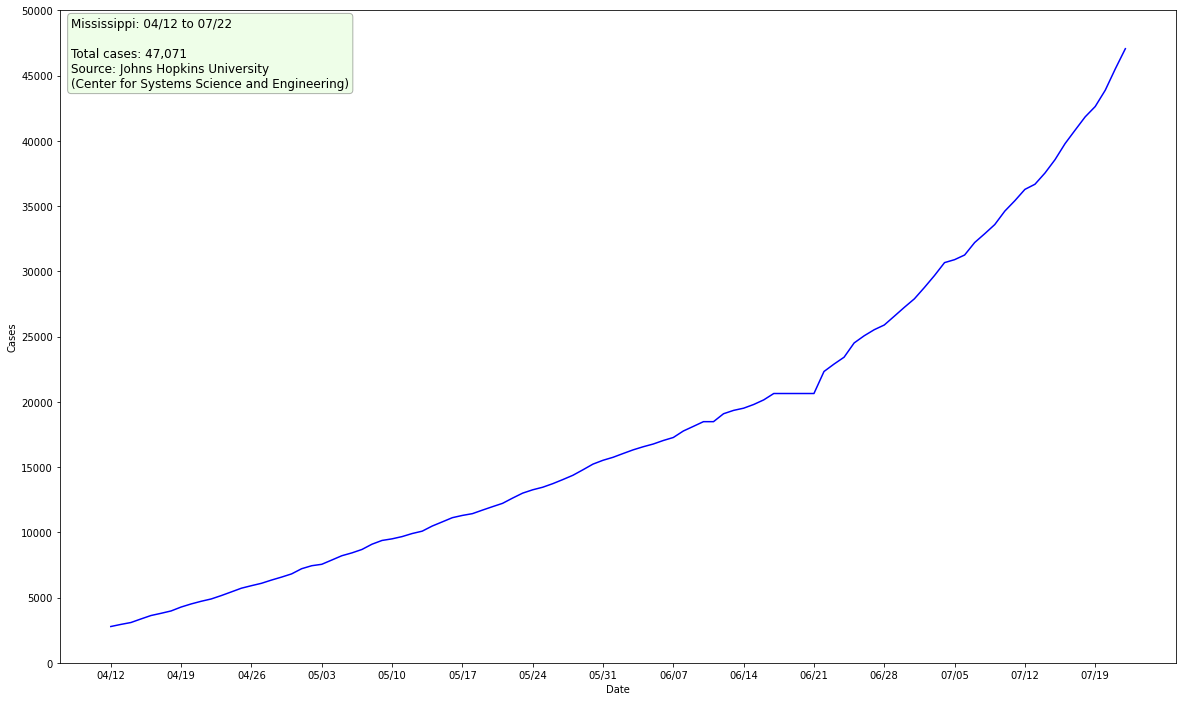

In [36]:
ax, fig = plot_state('Mississippi', image_file="jhu-ms-cases.png", metrics={MetricType.CASES})

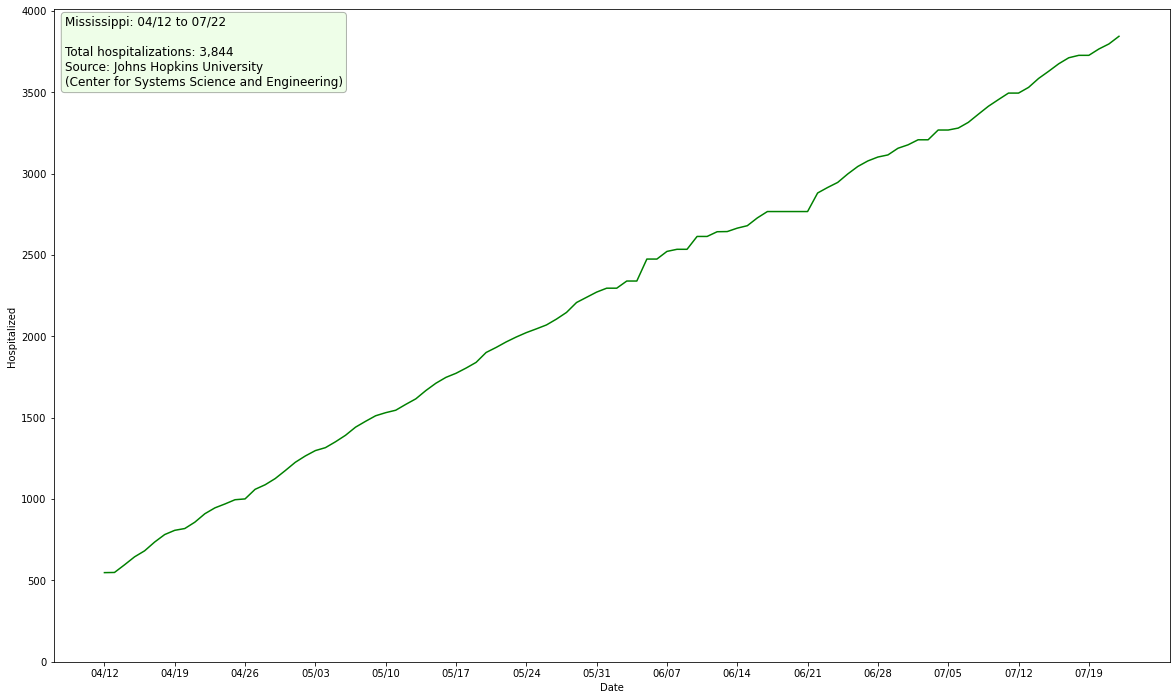

In [37]:
ax, fig = plot_state('Mississippi', image_file="jhu-ms-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

### Arizona

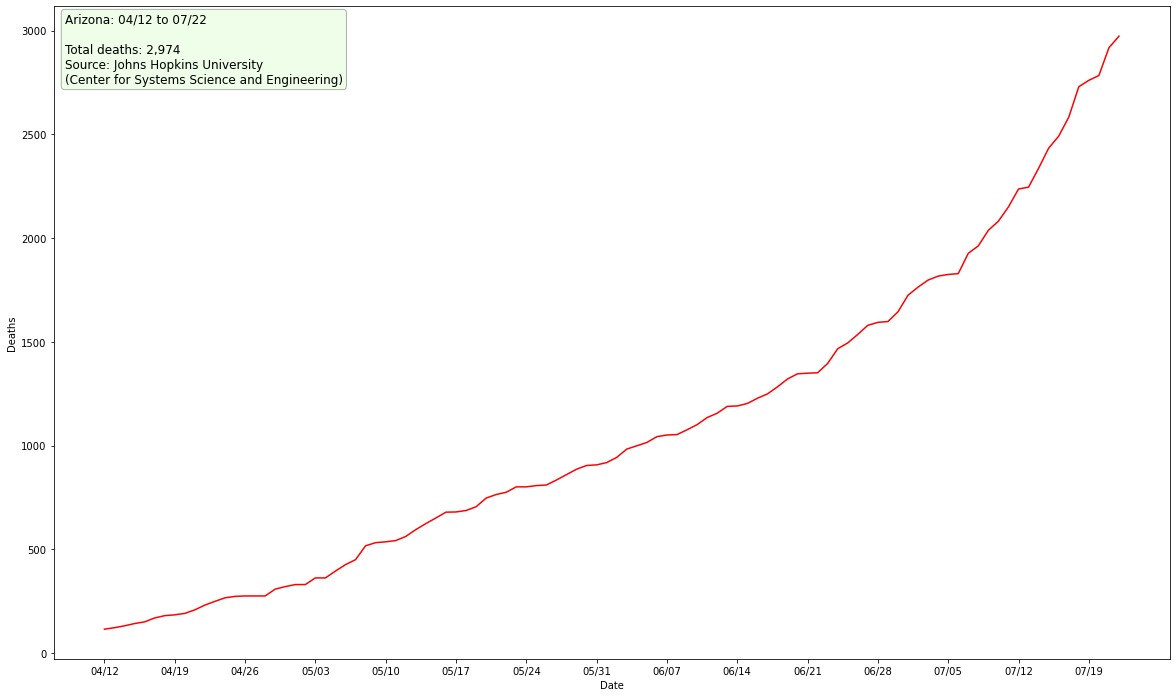

In [38]:
ax, fig = plot_state('Arizona', image_file="jhu-az-deaths.png")

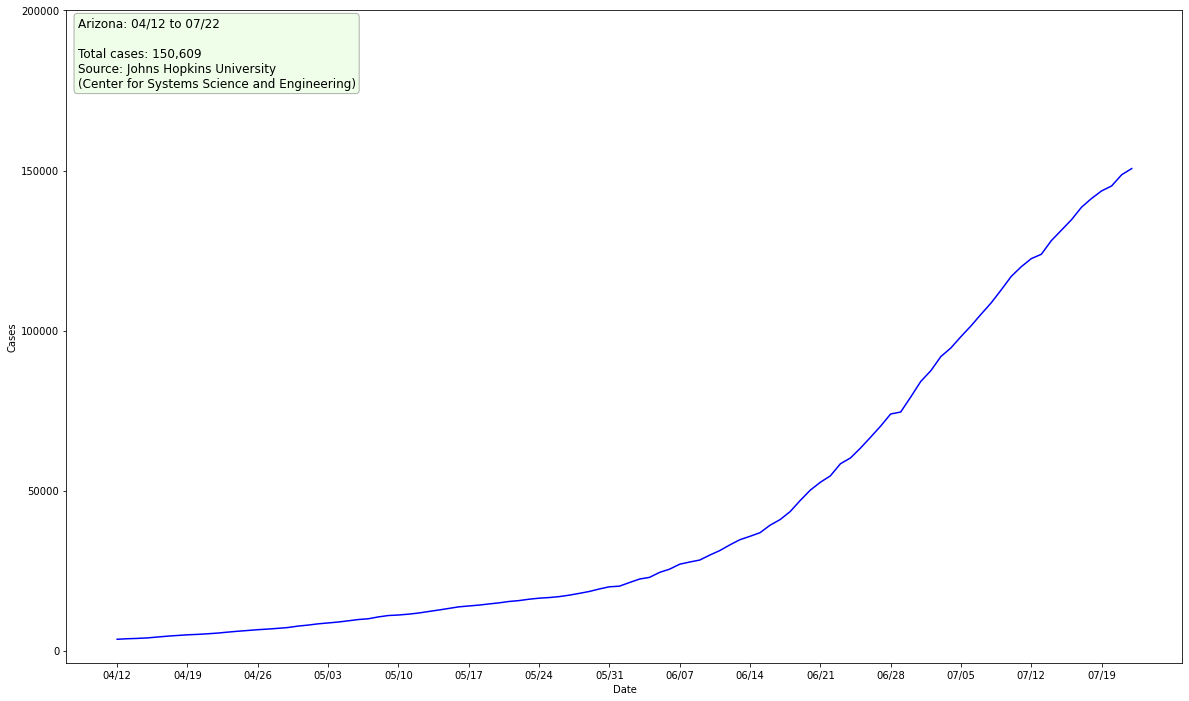

In [39]:
ax, fig = plot_state('Arizona', image_file="jhu-az-cases.png", metrics={MetricType.CASES})

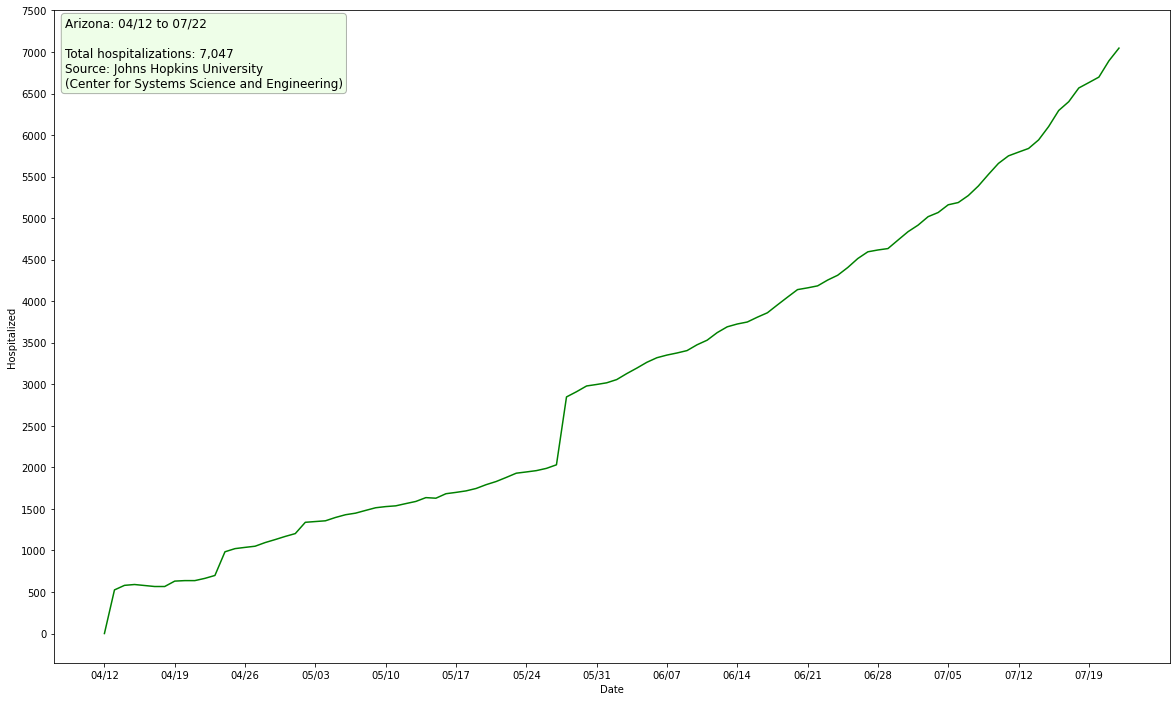

In [40]:
ax, fig = plot_state('Arizona', image_file="jhu-az-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

### Florida

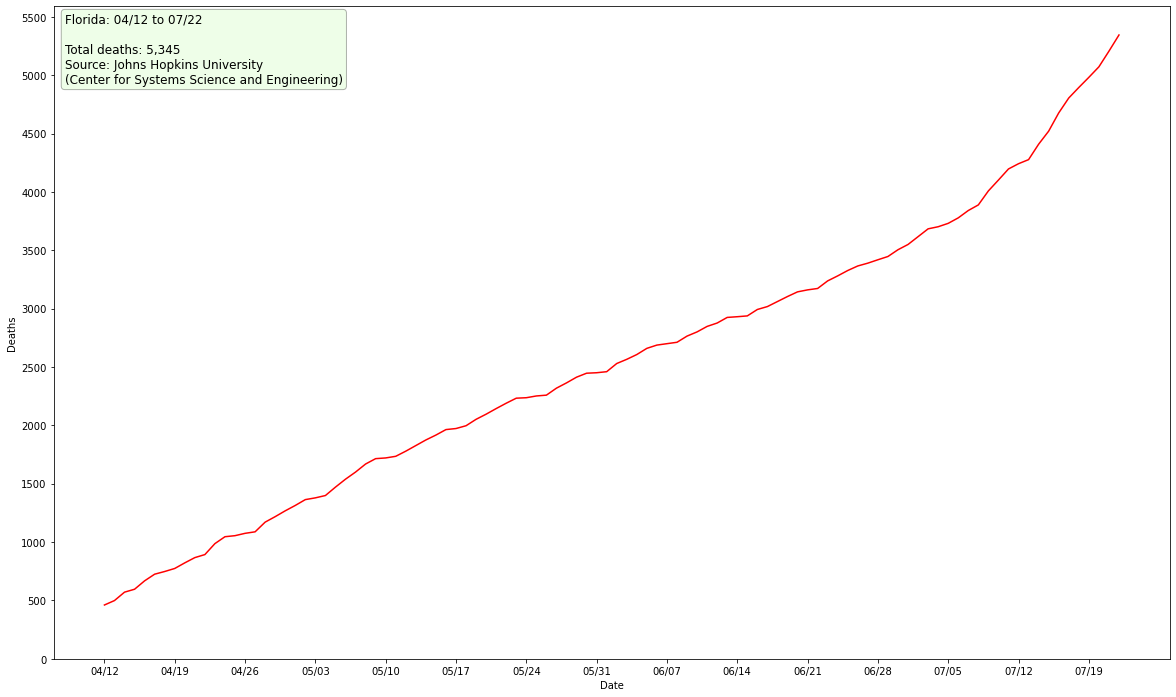

In [41]:
ax, fig = plot_state('Florida', image_file="jhu-fl-deaths.png", metrics={MetricType.DEATHS})

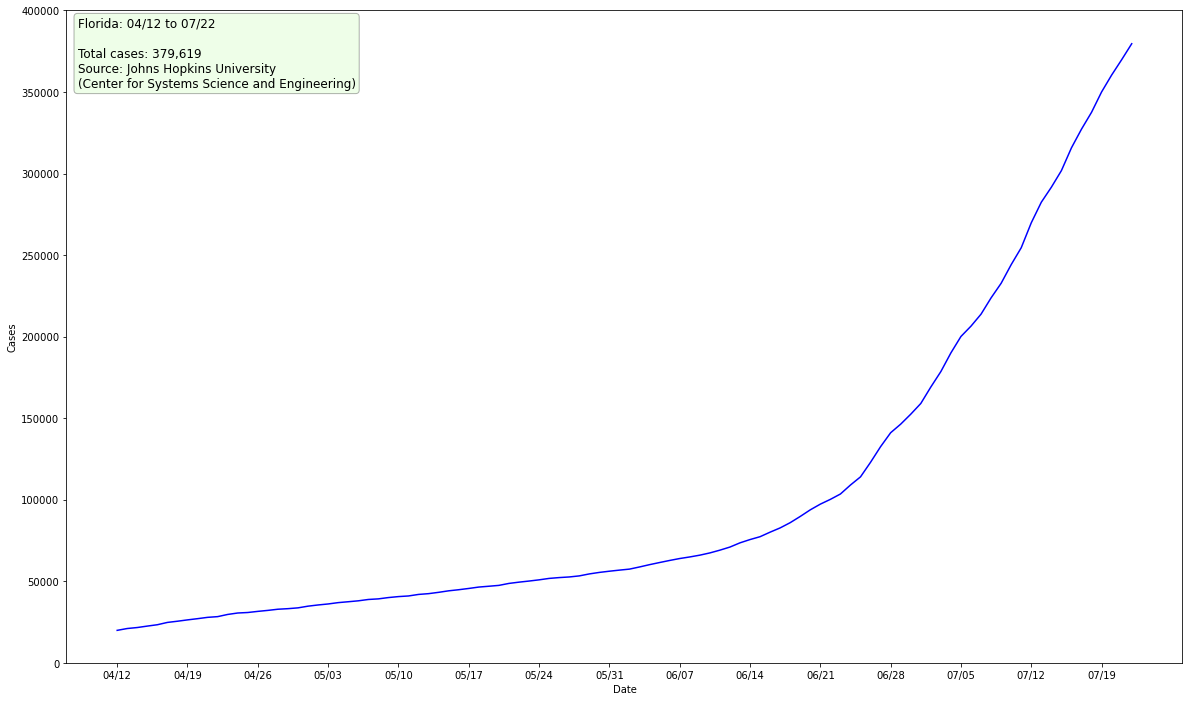

In [42]:
ax, fig = plot_state('Florida', image_file="jhu-fl-cases.png", metrics={MetricType.CASES})

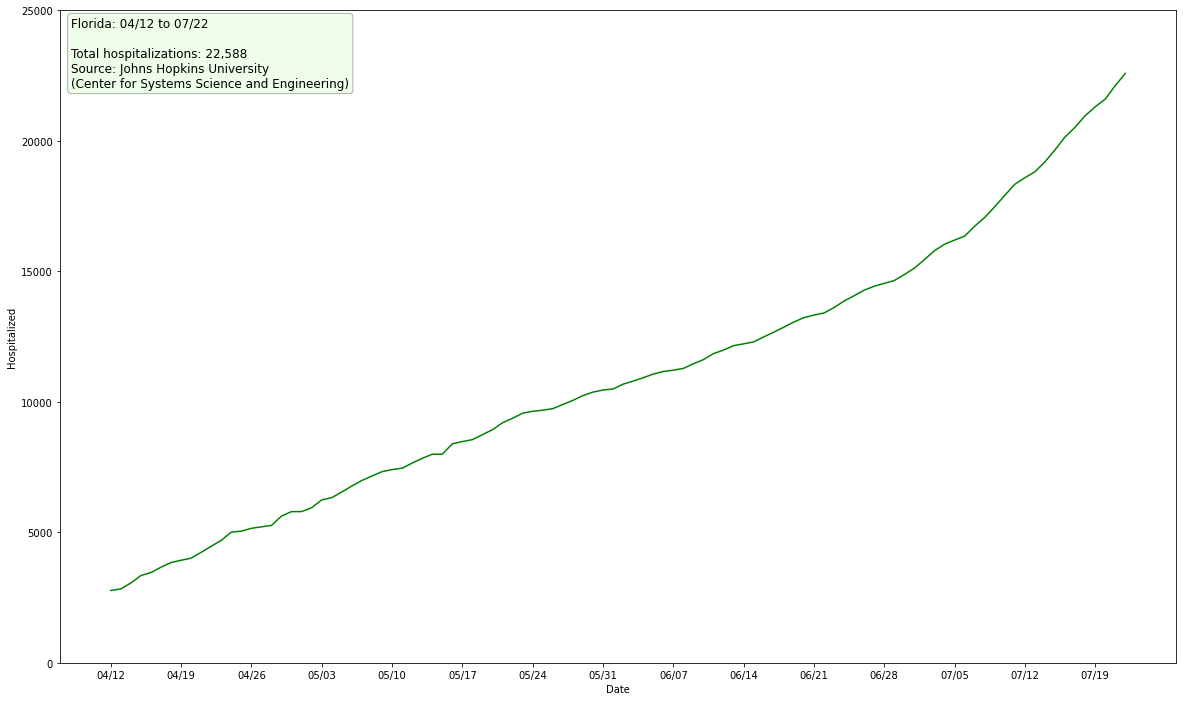

In [43]:
ax, fig = plot_state('Florida', image_file="jhu-fl-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

### South Carolina

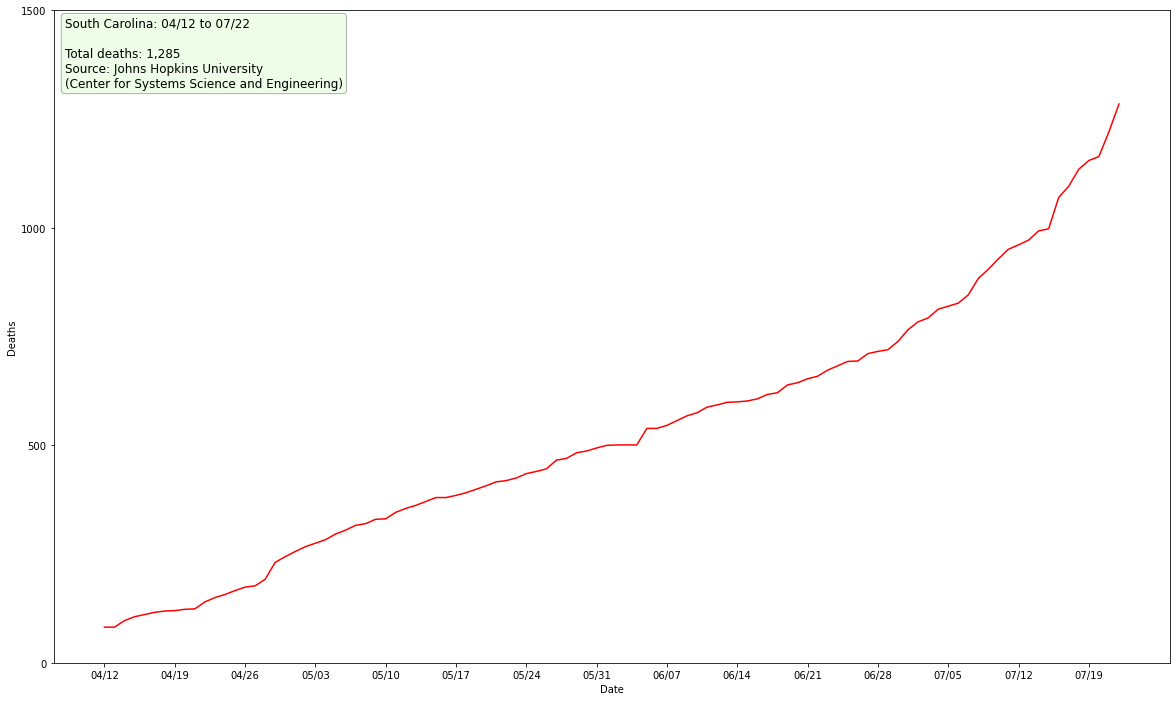

In [44]:
ax, fig = plot_state('South Carolina', image_file="jhu-sc-deaths.png", metrics={MetricType.DEATHS})

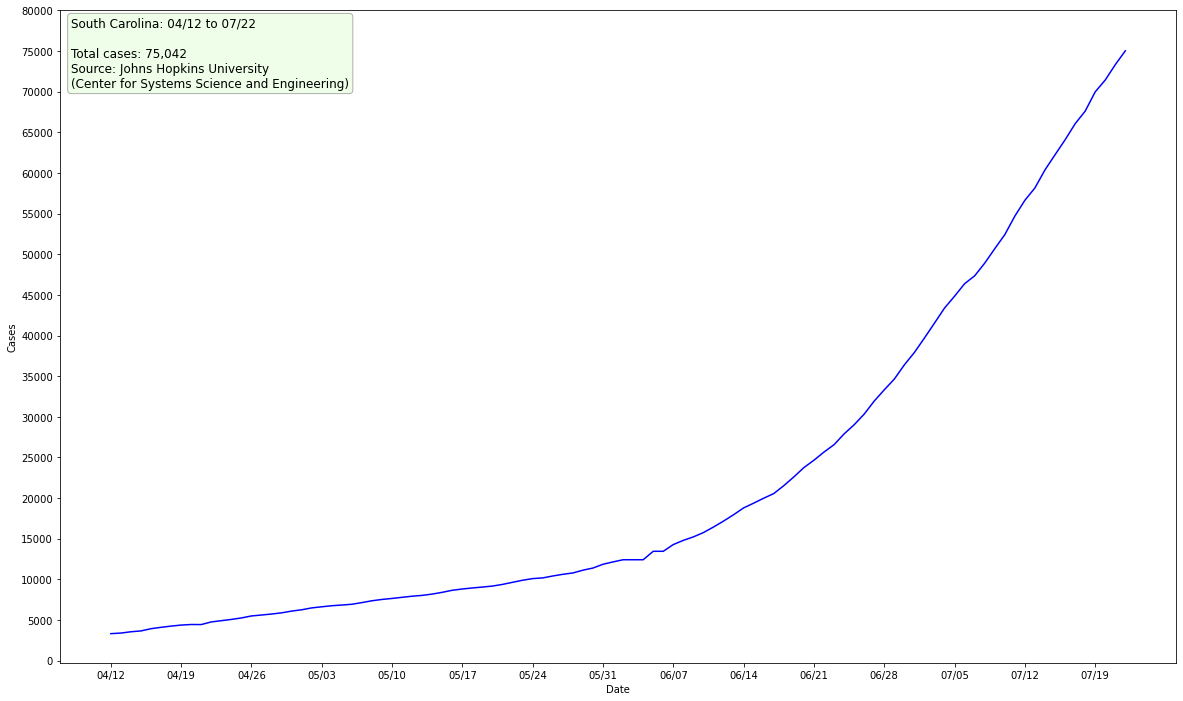

In [45]:
ax, fig = plot_state('South Carolina', image_file="jhu-sc-cases.png", metrics={MetricType.CASES})

### Oklahoma

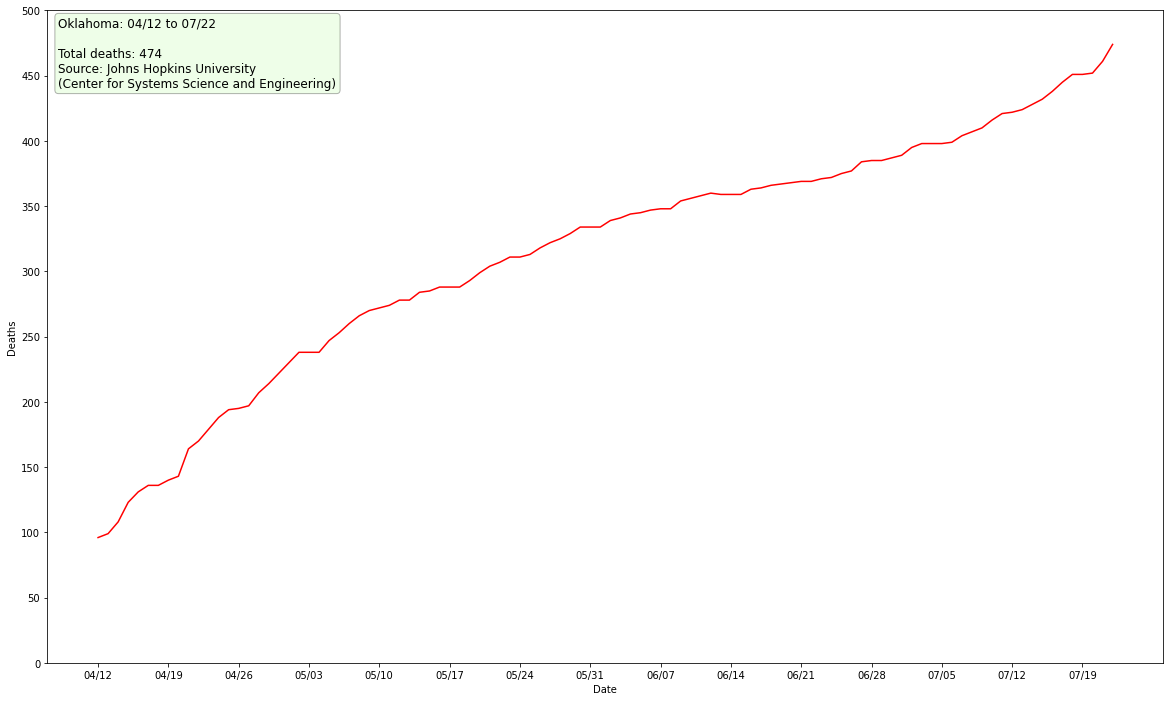

In [46]:
ax, fig = plot_state('Oklahoma', image_file="jhu-ok-deaths.png", metrics={MetricType.DEATHS})

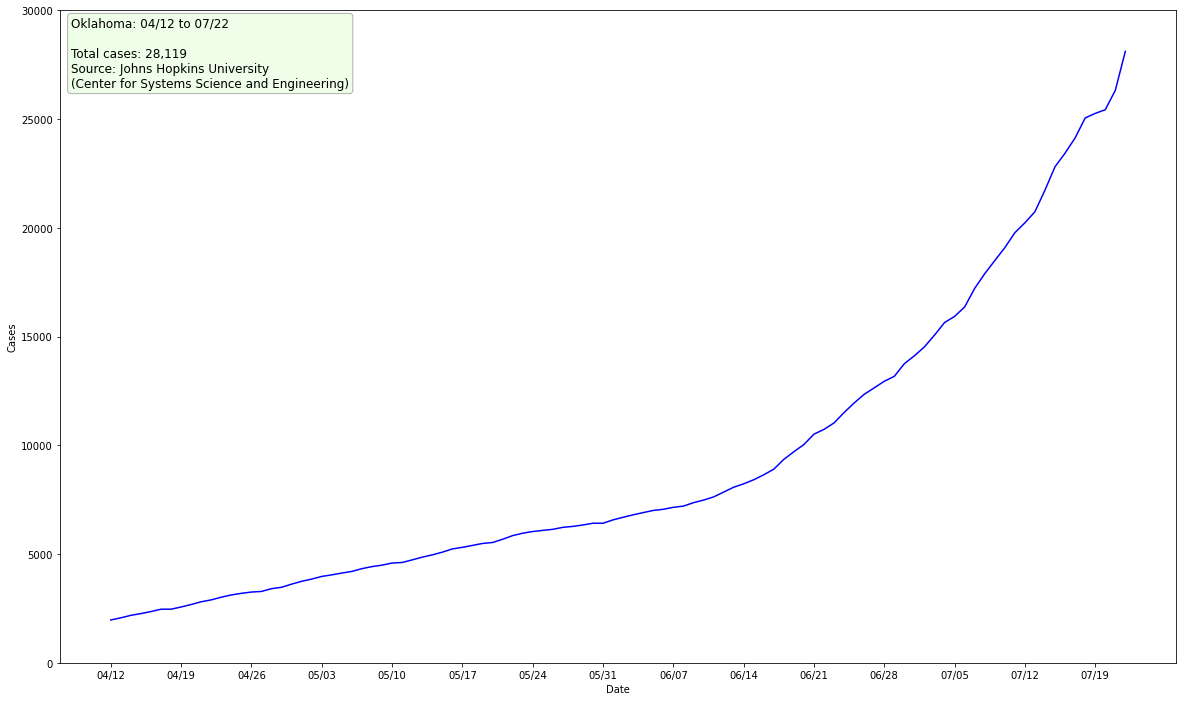

In [47]:
ax, fig = plot_state('Oklahoma', image_file="jhu-ok-cases.png", metrics={MetricType.CASES})

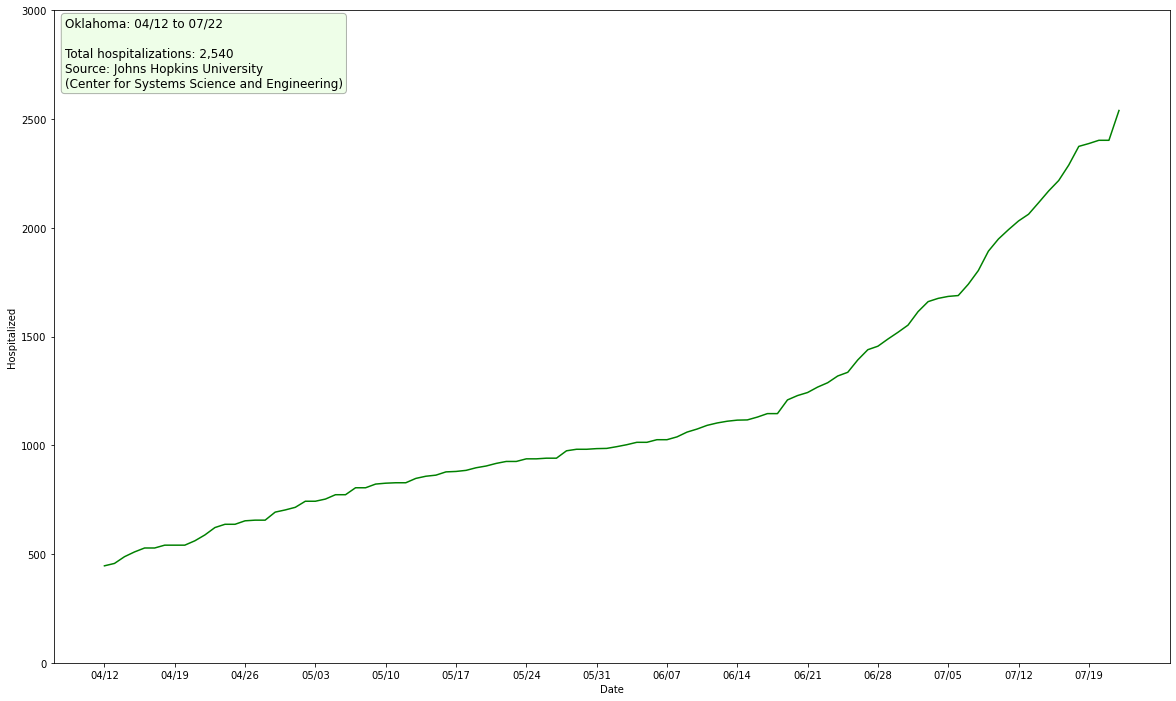

In [48]:
ax, fig = plot_state('Oklahoma', image_file="jhu-ok-hosp.png", metrics={MetricType.HOSPITALIZATIONS})

## Multistate

In [49]:
XY_TEXT_DEFAULT = (0.01, 0.98)
def jhu_plot_states(jhu_data, states, xy_text=XY_TEXT_DEFAULT, image_file=None, metric=MetricType.DEATHS, 
                    start_date=None, per_capita=False, per_n=100_000, plot_us_per_capita=False):
    fig, ax = p.subplots(figsize=(20, 11))

    dates = dates_in_order
    if start_date is not None:
        dates = [d for d in dates if d >= start_date]

    total_deaths_by_state = dict()
    total_cases_by_state = dict()
    total_tested_by_state = dict()
    for state, (color, linestyle) in zip(states, LINE_COLORS_AND_STYLES):
        x_dates = [datestr(d) for d in dates]
        total_deaths = []
        total_cases = []
        total_tested = []
        for date in dates:
            data = jhu_data[date][state]
            if per_capita:
                state_pop = populations[state]
                total_deaths.append(get_per_capita_int(data.deaths, state_pop, per_n=per_n))
                total_cases.append(get_per_capita_int(data.cases, state_pop, per_n=per_n))
                total_tested.append(get_per_capita_int(data.tested, state_pop, per_n=per_n))

            else:
                total_deaths.append(data.deaths)
                total_cases.append(data.cases)
                total_tested.append(data.tested)

        to_plot = total_deaths if metric == MetricType.DEATHS else total_cases
        ax.plot(x_dates, to_plot, color=color, label=state, linestyle=linestyle, zorder=1)
        total_deaths_by_state[state] = total_deaths[-1]
        total_cases_by_state[state] = total_cases[-1]
        total_tested_by_state[state] = total_tested[-1]

    last_day = jhu_data[dates[-1]]
    us_total = 0
    if metric == MetricType.DEATHS:
        us_total = sum([j.deaths for j in last_day.values()])
    elif metric == MetricType.TESTED:
        us_total = sum([j.tested for j in last_day.values()])
    else:
        us_total = sum([j.cases for j in last_day.values()])

    if per_capita:
        us_total = get_per_capita_int(us_total, populations["United States"], per_n=per_n)
        
    max_y = 0
    if metric == MetricType.DEATHS:
        metric_label = 'Deaths'
        max_y = max(total_deaths_by_state.values())
    elif metric == MetricType.TESTED:
        metric_label = 'Tested'
        max_y = max(total_tested_by_state.values())
    else:
        metric_label = 'Cases'
        max_y = max(total_cases_by_state.values())

    if len(x_dates) > 14:
        x_ticks = x_dates[::7]
        ax.set_xticks(x_dates[::7]) # X axis ticks every 7 days

    ymax, stride = determine_ymax_and_stride(max_y)
    # Boost ymax, to account for text boxes. This factor is based on
    # experimentation.
    factor = float(len(states)) * 0.06
    ymax = int(ymax + (float(ymax) * factor))

    y_ticks = list(range(0, ymax)[::stride])
    if per_capita and plot_us_per_capita:
        y_ticks.append(us_total)
        ax.axhline(us_total, color='gray', linestyle='dashed', zorder=0)
        #ax.fill_between(x_dates, us_total, color='xkcd:off white')

    ax.set_yticks(y_ticks)
    ax.set_xlabel('Date')
    if per_capita:
        metric_label = f"{metric_label} per {per_n:,}"

    ax.set_ylabel(metric_label)
    ax.legend()

    if per_capita:
        text_lines = [f"CURRENT {metric_label.upper()}", ""]
    else:
        text_lines = [f"TOTAL {metric_label.upper()}", ""]

    text_lines.append(f"United States: {us_total:,}")
    if metric == MetricType.DEATHS:
        to_sum = total_deaths_by_state
    elif metric == MetricType.CASES:
        to_sum = total_cases_by_state
    else:
        to_sum = total_tested_by_state

    for state, count in sorted(to_sum.items(), key=lambda v: v[1], reverse=True):
         text_lines.append(f"{state}: {count:,}")

    text = '\n'.join(text_lines)
    text_x, text_y = xy_text
    def_x, def_y = XY_TEXT_DEFAULT
    text_x = text_x or def_x
    text_y = text_y or def_y
    textbox(ax, text_x, text_y, text)
    if image_file is not None:
        fig.savefig(os.path.join(IMAGES_PATH, image_file))
    return fig, ax

### Comparing various states

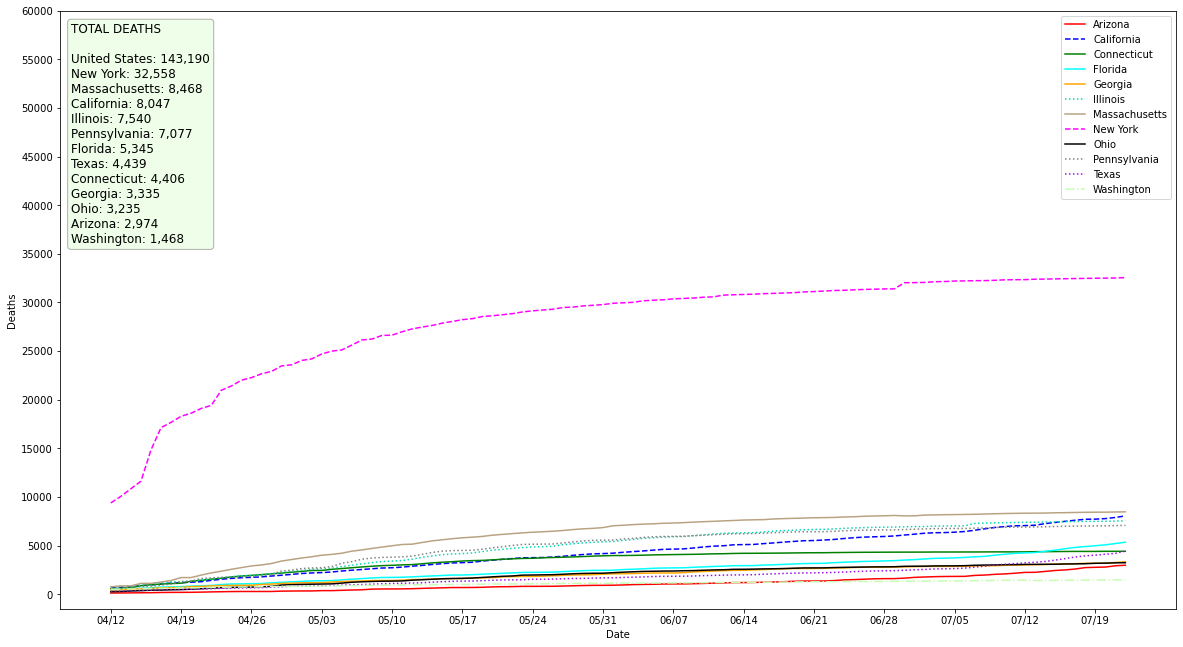

In [50]:
fig, ax = jhu_plot_states(jhu_data, STATES_TO_COMPARE, image_file='jhu-states1-deaths.png')

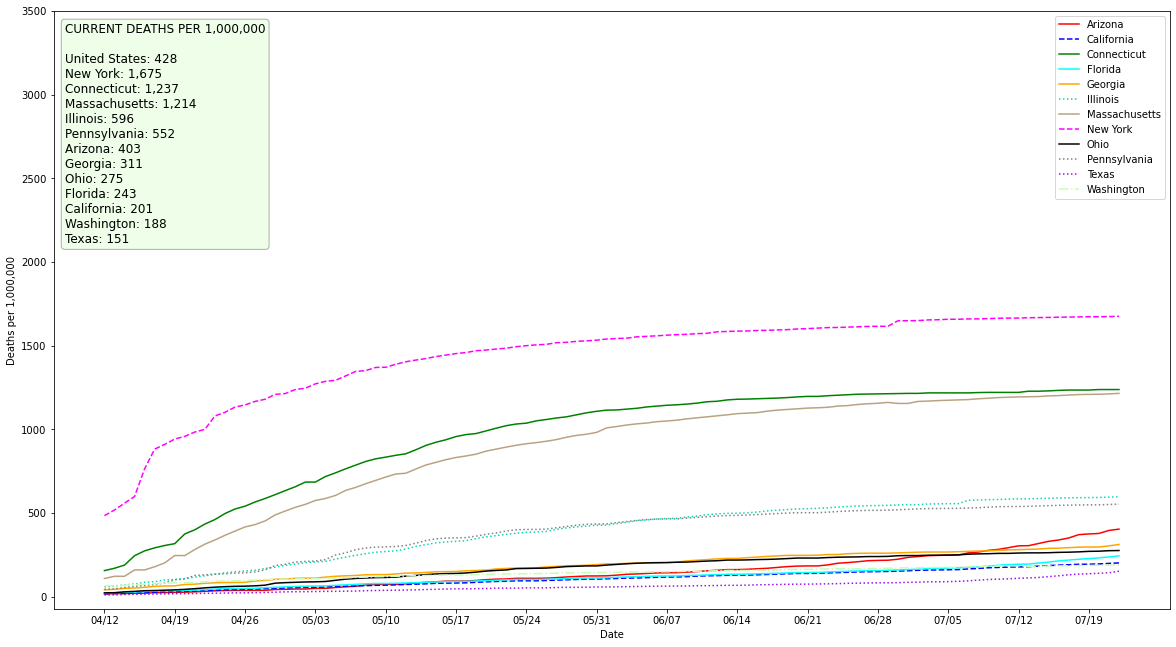

In [51]:
fig, ax = jhu_plot_states(jhu_data, STATES_TO_COMPARE, image_file='jhu-states1-deaths-per-capita.png', per_capita=True, per_n=1_000_000)

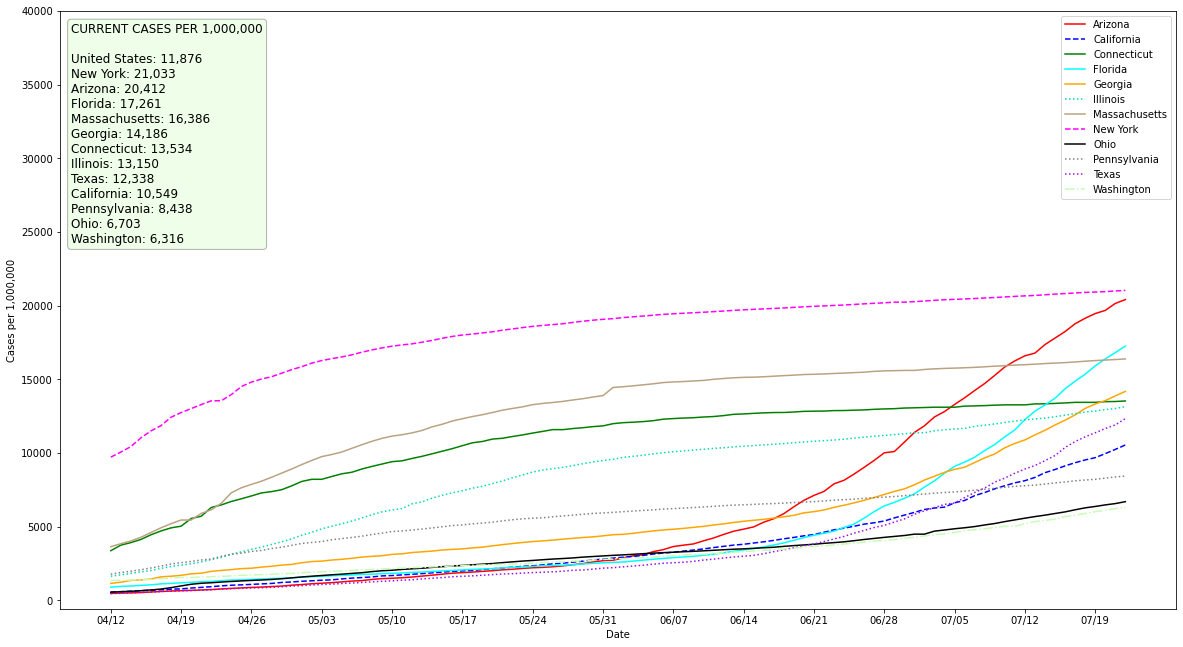

In [52]:
fig, ax = jhu_plot_states(jhu_data, STATES_TO_COMPARE, image_file='jhu-states1-cases-per-capita.png',
                          metric=MetricType.CASES, per_capita=True, per_n=1_000_000)

### Same states, but without New York

New York, as a hotspot, skews the graph.

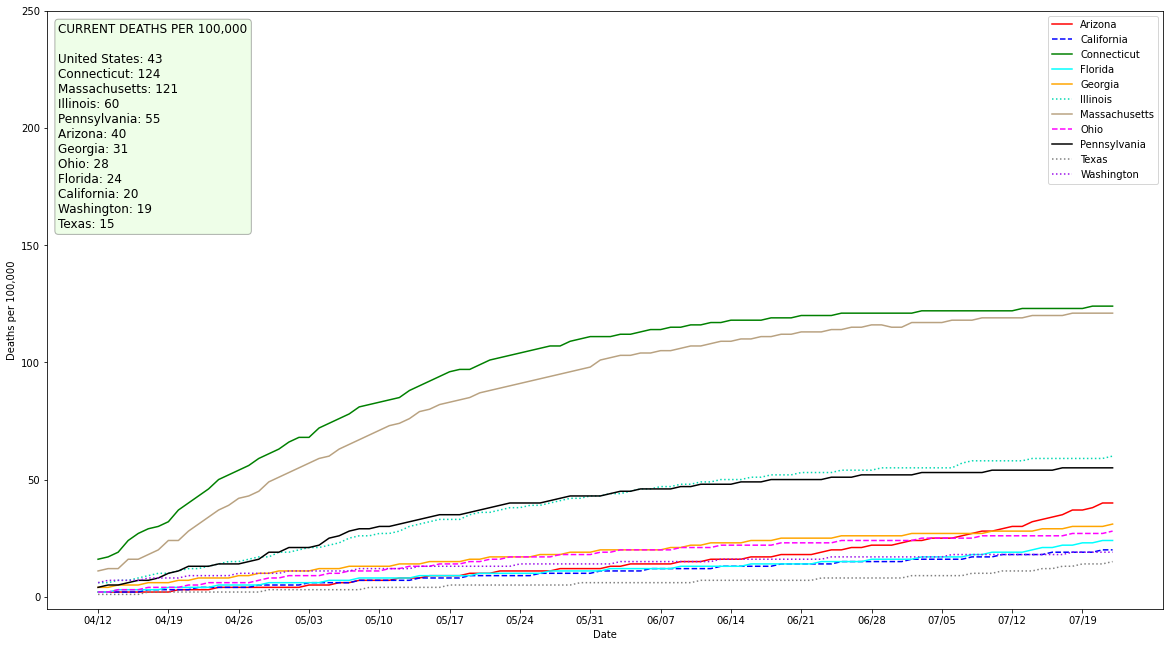

In [53]:
without_ny = sorted(list(set(STATES_TO_COMPARE) ^ set(('New York',))))
fig, ax = jhu_plot_states(jhu_data, without_ny, image_file='jhu-states2-deaths-per-capita.png', per_capita=True)

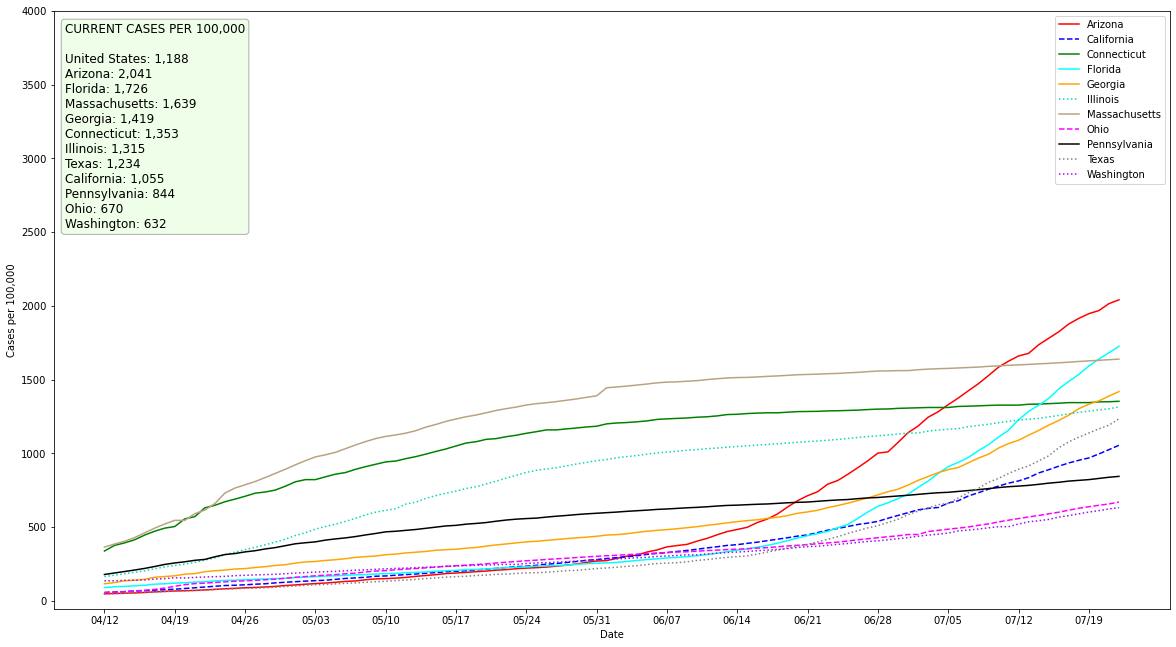

In [54]:
fig, ax = jhu_plot_states(jhu_data, without_ny, image_file='jhu-states2-cases-per-capita.png', 
                          metric=MetricType.CASES, per_capita=True)

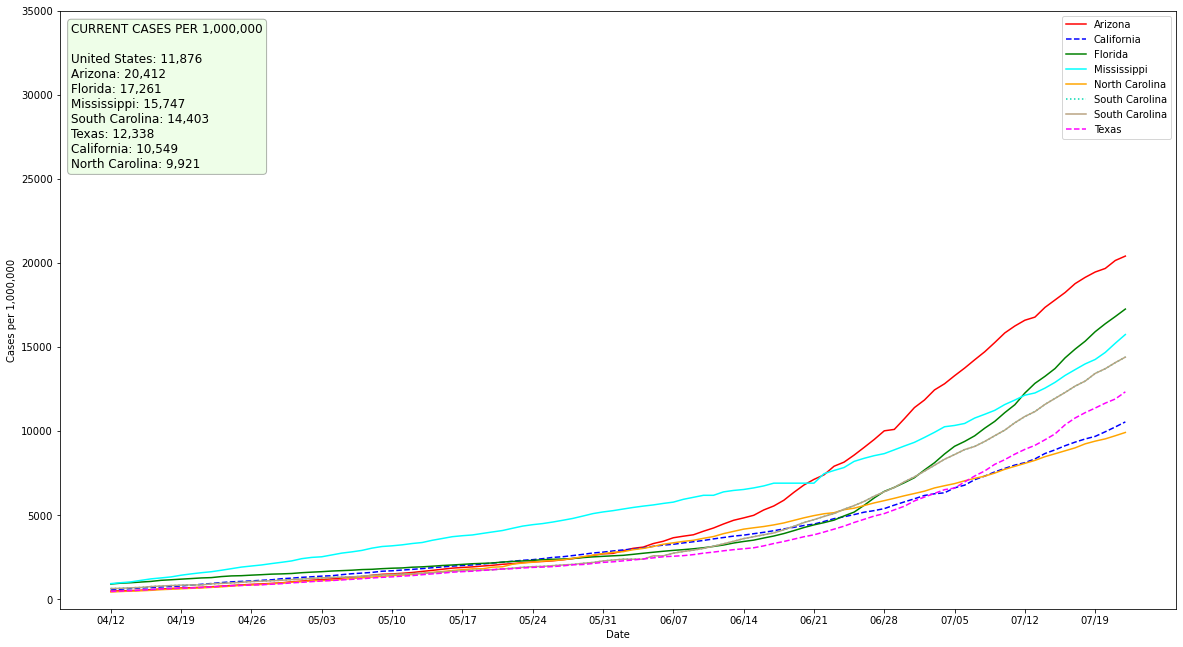

In [55]:
spiky_states = tuple(sorted(('Arizona', 'Florida', 'South Carolina', 'Texas', 'California',
                             'Mississippi', 'South Carolina', 'North Carolina')))
fig, ax = jhu_plot_states(jhu_data, spiky_states, image_file='jhu-states3-cases-per-capita.png', 
                          metric=MetricType.CASES, per_capita=True, per_n=1_000_000)

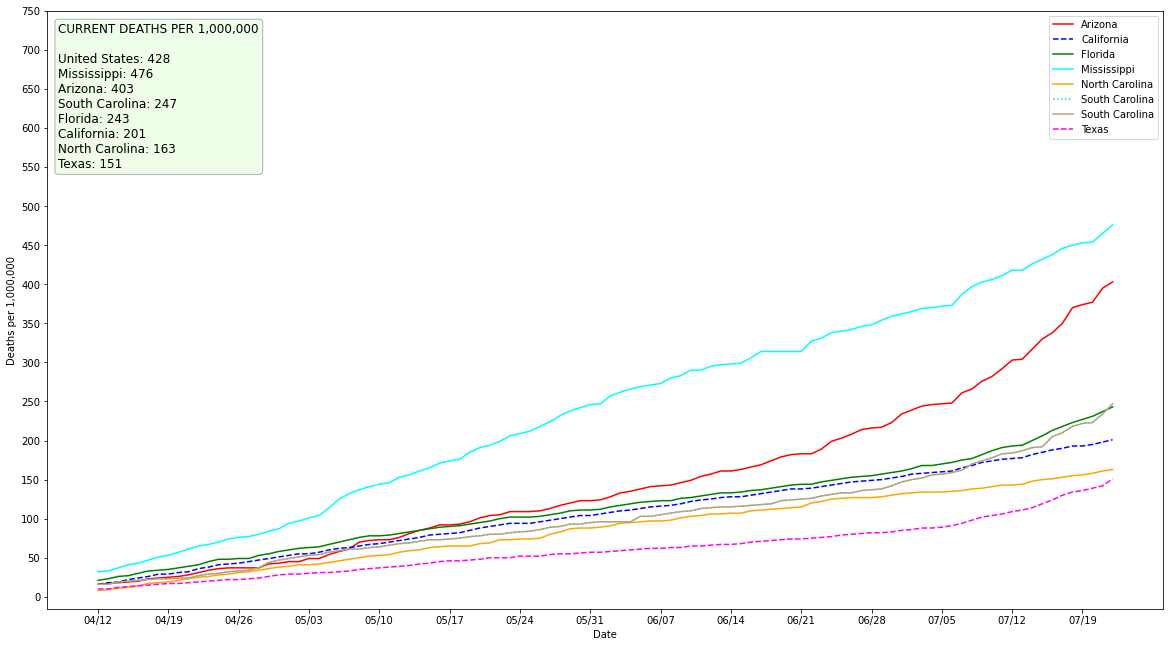

In [56]:
fig, ax = jhu_plot_states(jhu_data, spiky_states, image_file='jhu-states3-deaths-per-capita.png', 
                          metric=MetricType.DEATHS, per_capita=True, per_n=1_000_000)

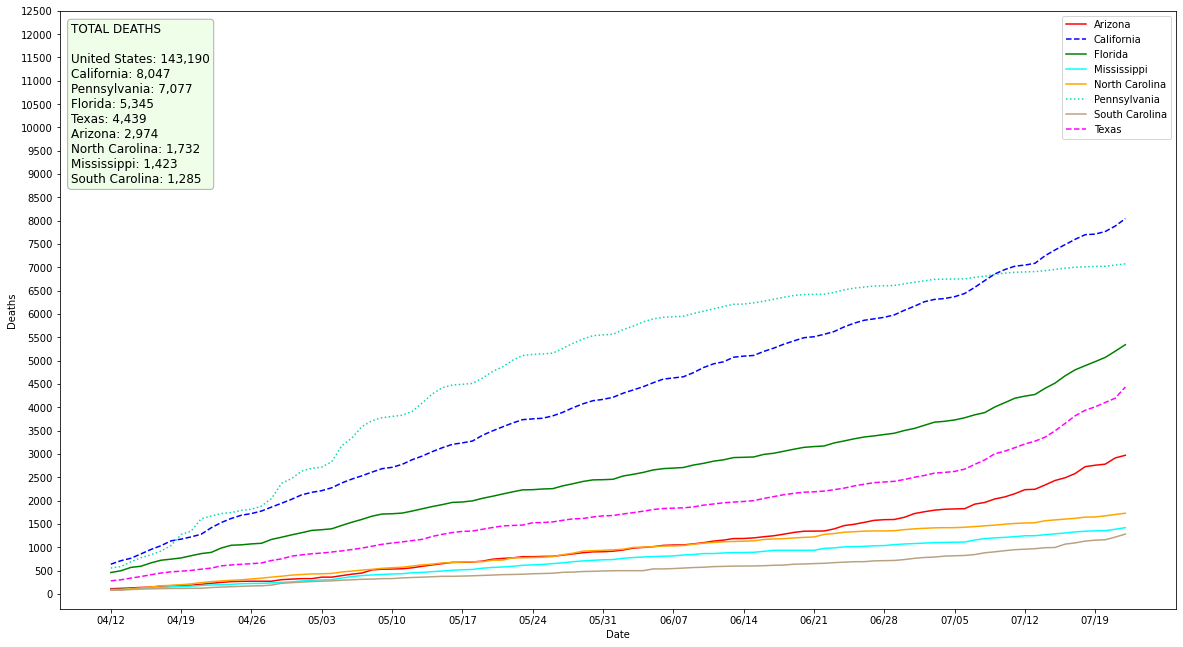

In [57]:
states_with_pa = sorted(tuple(set(spiky_states + ('Pennsylvania',))))
fig, ax = jhu_plot_states(jhu_data, states_with_pa, image_file='jhu-states4-deaths.png', metric=MetricType.DEATHS)

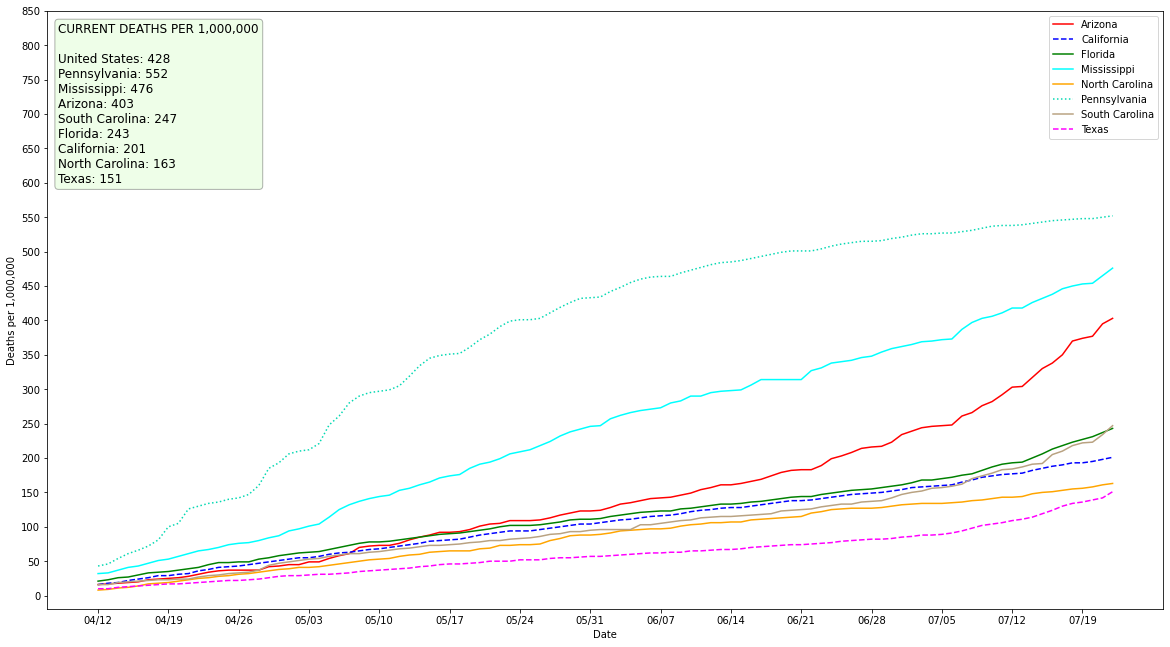

In [58]:
fig, ax = jhu_plot_states(jhu_data, states_with_pa, image_file='jhu-states4-deaths-per-capita.png',
                          metric=MetricType.DEATHS, per_capita=True, per_n=1_000_000)

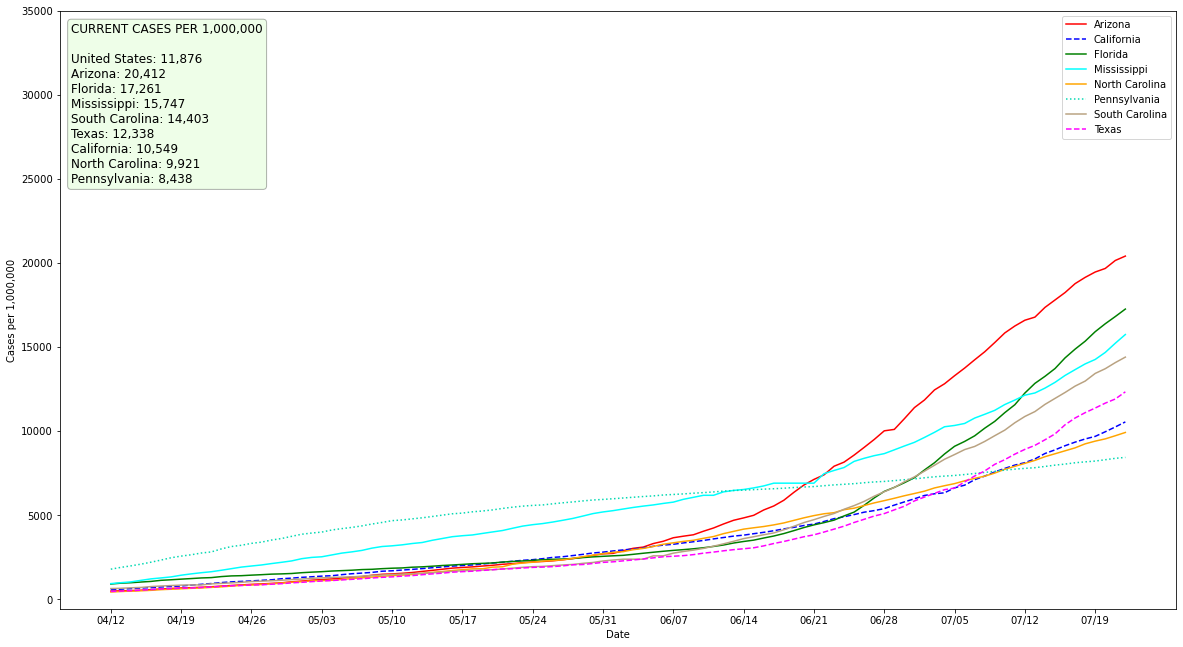

In [59]:
fig, ax = jhu_plot_states(jhu_data, states_with_pa, image_file='jhu-states4-cases-per-capita.png', 
                          metric=MetricType.CASES, per_capita=True, per_n=1_000_000)

## Per-capita rates for all states

In [60]:
# First, get the data

max_deaths = 0
max_cases = 0
us_deaths = 0
us_cases = 0
state_per_capita_deaths = dict()
state_per_capita_cases = dict()
state_info = load_state_info()
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    state_deaths = jhu_data[jhu_ending_date][state].deaths
    state_cases = jhu_data[jhu_ending_date][state].cases
    us_deaths += state_deaths
    us_cases += state_cases
    per_capita_deaths = get_per_capita_value(state_deaths, populations[state], per_n=100_000)
    state_per_capita_deaths[state] = int(round(per_capita_deaths))
    per_capita_cases = get_per_capita_value(state_cases, populations[state], per_n=100_000)
    state_per_capita_cases[state] = int(round(per_capita_cases))
    rounded_up = int(round(per_capita_deaths))
    
us_pop = populations['United States']
us_per_capita_deaths = int(round(get_per_capita_value(us_deaths, us_pop)))
us_per_capita_cases = int(round(get_per_capita_value(us_cases, us_pop)))

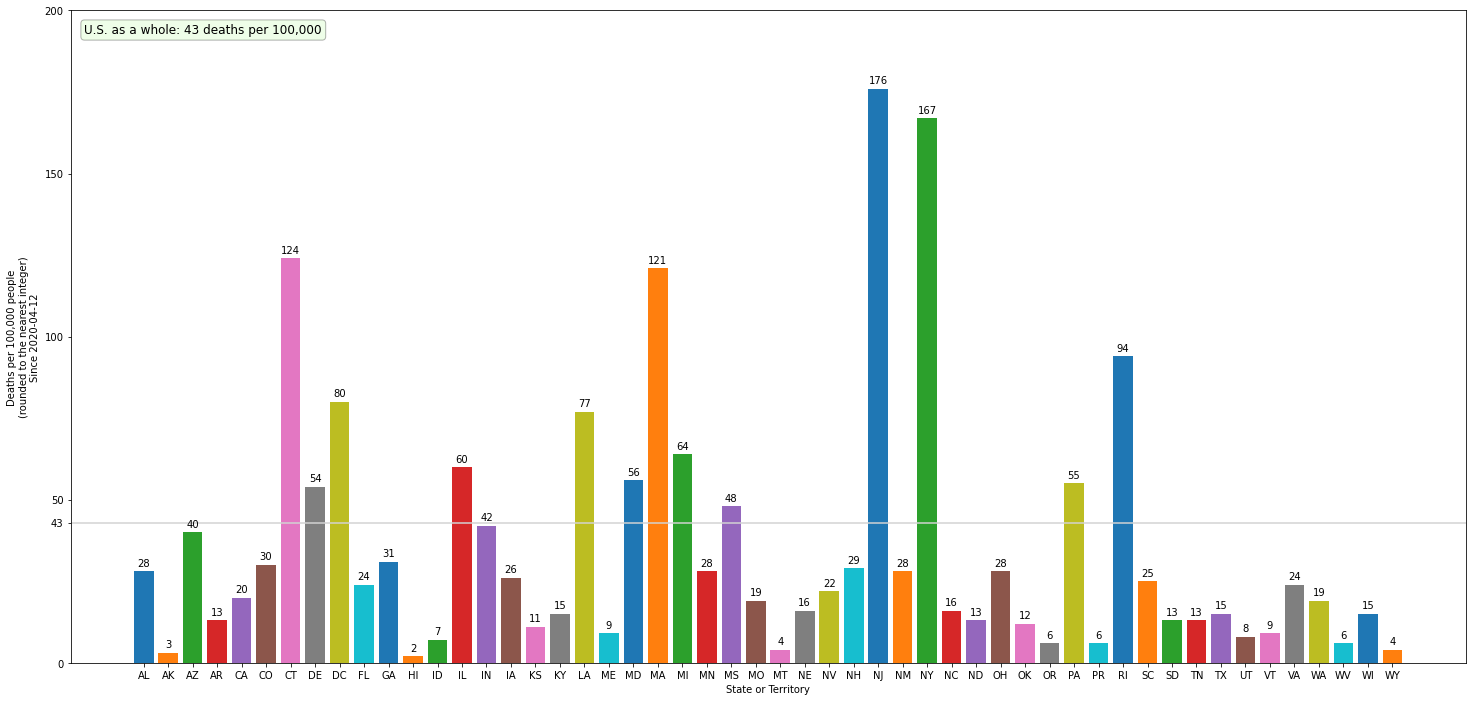

In [61]:
# Deaths

fig, ax = p.subplots(figsize=(25, 12))

bar_labels = []
max_value = 0
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    abbrev = state_info[state].abbreviation
    value = state_per_capita_deaths[state]
    ax.bar(abbrev, value)
    bar_labels.append(f"{value}")
    max_value = max(max_value, value)
    
ax.axhline(us_per_capita_deaths, color="lightgray")

ymax, stride = determine_ymax_and_stride(max_value)
ax.set_yticks(list(range(0, ymax))[::stride] + [us_per_capita_deaths])
ax.set_ylabel(f'Deaths per 100,000 people\n(rounded to the nearest integer)\nSince {jhu_starting_date}')
ax.set_xlabel('State or Territory')

# See https://stackoverflow.com/a/28931750
for rect, label in zip(ax.patches, bar_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

textbox(ax, 0.01, 0.98, f"U.S. as a whole: {us_per_capita_deaths:,} deaths per 100,000")
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-state-per-capita-deaths.png'))

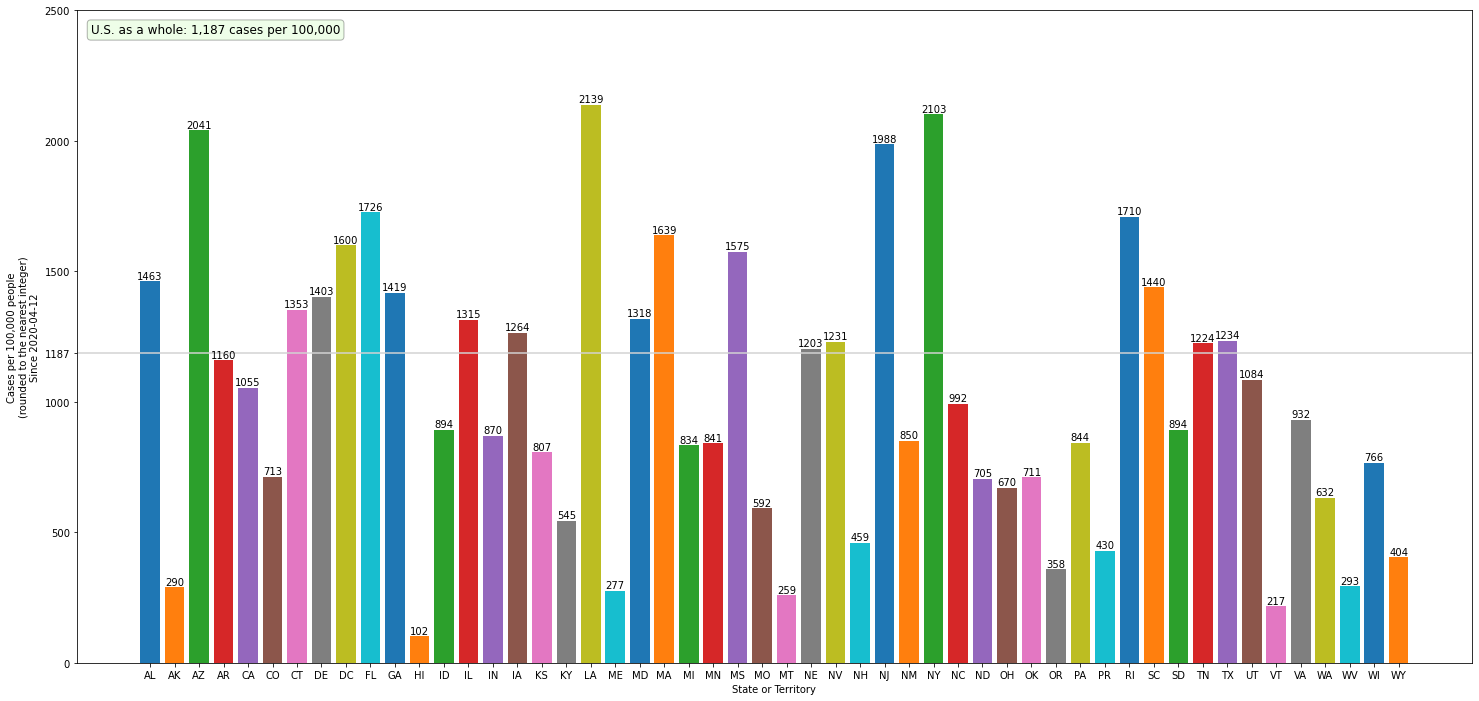

In [62]:
# Cases

fig, ax = p.subplots(figsize=(25, 12))

bar_labels = []
max_value = 0
for state in sorted(populations.keys()):
    if state == 'United States':
        continue

    abbrev = state_info[state].abbreviation
    value = state_per_capita_cases[state]
    ax.bar(abbrev, value)
    bar_labels.append(f"{value}")
    max_value = max(max_value, value)
    
ax.axhline(us_per_capita_cases, color="lightgray")

ymax, stride = determine_ymax_and_stride(max_value)
ax.set_yticks(list(range(0, ymax))[::stride] + [us_per_capita_cases])
ax.set_ylabel(f'Cases per 100,000 people\n(rounded to the nearest integer)\nSince {jhu_starting_date}')
ax.set_xlabel('State or Territory')

# See https://stackoverflow.com/a/28931750
for rect, label in zip(ax.patches, bar_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label, ha='center', va='bottom')

textbox(ax, 0.01, 0.98, f"U.S. as a whole: {us_per_capita_cases:,} cases per 100,000")
fig.savefig(os.path.join(IMAGES_PATH, 'jhu-state-per-capita-cases.png'))